In [ ]:
# This code was written by Luka Skolc (ETHZ) under the supervision of Krzysztof Barczynski (PMOD/WRC & ETHZ),
# Nils Janitzek (PMOD/WRC & ETHZ) and Louise Harra (PMOD/WRC & ETHZ) in the scope of the ETH Studio 
# Davos Internship in 2023. The work on the code began in March 2023.

In [1]:
import sunpy.map
import sunpy.data.sample  
import sunpy

import numpy as np
import scipy.optimize as so
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation

from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch

from IPython.display import HTML

%matplotlib notebook


In [15]:
vmaxx = 1500 # Universal cutoffs for plotting intensities
vminn = 500
margin_plot = 20 # Margin around the object in separate plots
ccode = 'sdoaia171'

In [7]:
no_files = 600
indices = np.arange(600)

#smap_array_whole = np.zeros((2048, 2048, no_files)) # Array of intensities
smap_array_whole = np.zeros((130, 748, 300))
time_stamps = []

for i in range(300, no_files):
    #print(i)
    hi = fits.open('/Users/lukas/Documents/eui_data_corrected/' + make_index(indices[i]) + '.fits')
    time_stamps.append(hi[0].header['DATE-OBS'][:-4])
    smap_array_whole[:, :, i-300] = hi[0].data[600:730, 1300:]
    hi.close()


intens = smap_array_whole[:, :, :]


In [8]:
print(time_stamps[0])
print(time_stamps[-1])


30-Mar-2022 04:45:00
30-Mar-2022 04:59:57


In [ ]:
plt.imshow(smap_array_whole[:, :, 0], origin = 'lower', norm = colors.LogNorm(vmin = vminn, vmax = vmaxx),)
plt.show()
plt.imshow(intens[:, :, 0], origin = 'lower', norm = colors.LogNorm(vmin = vminn, vmax = vmaxx),)
plt.show()


<IPython.core.display.Javascript object>


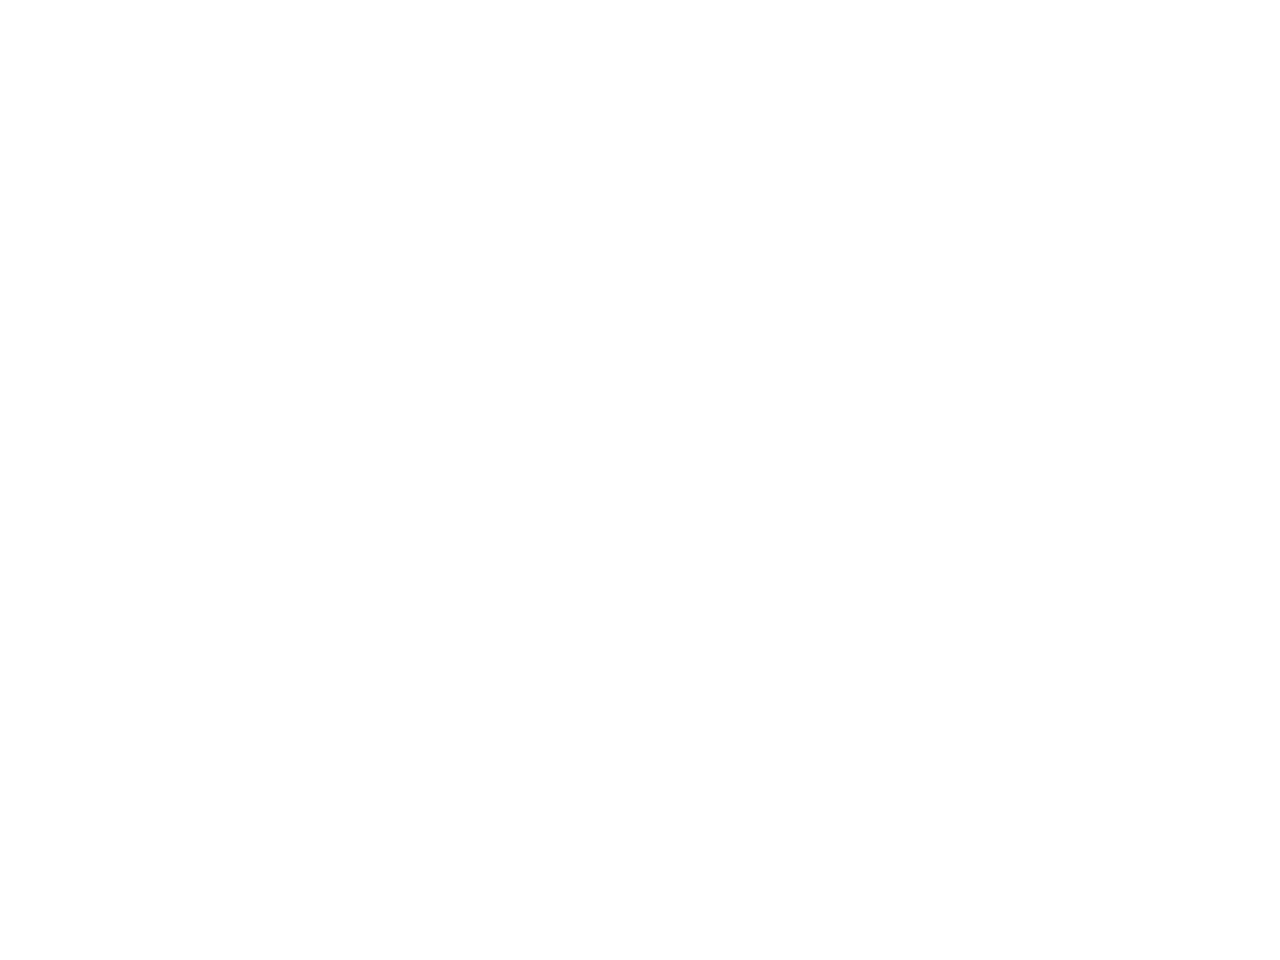

In [9]:
# Make an animation of the cutout
(ny, nx, nt) = intens.shape
fig = plt.figure()
ax = fig.add_subplot(111)

img = [None]
def update_img(i):
    #ax.set_title(str(smap[i].date)[:-12] + ' ' + str(smap[i].date)[-12:-4], fontsize = 15) 
    ax.set_title(time_stamps[i], fontsize = 15) 
    if img[0]: 
        img[0].remove()
    img[0] = ax.imshow(intens[:, :, i], norm = colors.LogNorm(vmin = vminn, vmax = vmaxx), origin = 'lower', cmap = 'sdoaia171', animated=True)

ani = animation.FuncAnimation(fig, update_img, frames = np.arange(nt), blit = False, repeat = True)
plt.xlabel('x [pixels]', fontsize = 15)
plt.ylabel('y [pixels]', fontsize = 15)
plt.show()

writervideo = animation.FFMpegWriter(fps=10)
ani.save('whole_video_edge.mp4', writer = writervideo)
plt.close()


In [17]:
# Always run this cell after changing the two files. It's the same as importing functions. Note there
# may be variable name conflicts if you are not careful.

%run jet_func_detection.ipynb
%run jet_func_analysis.ipynb
%run jet_func_plotting.ipynb


In [10]:
objectss = []
(ny, nx, nt) = intens.shape

threshold = 1.3
t_smooth = 8  # The pixel-wise running mean value is smoothed over the last "t_smooth" frames
delayy = 8

mintime = 4     # Objects with a shorther lifetime than "mintime" will be removed
minsize = 6     # Objects with a smaller time union than "minsize" will be removed
maxsize = 10000 # Objects with a larger time union than "maxsize" will be removed

means_array = np.zeros((ny, nx, nt - t_smooth)) 
for tt in range(nt - t_smooth): # This is demanding for memory, you essentialy copy the "intens" array
    means_array[:, :, tt] = np.mean(intens[:, :, tt : tt + t_smooth], axis = 2)
    
###############################################################################################
for t in range(t_smooth + delayy, nt): # First expand, then add, then join, lastly filter
    #print(t)
    expand_objects(objectss, t, intens, means_array, threshold, t_smooth, delayy) 
    add_objects(objectss, t, intens, means_array, threshold, t_smooth, delayy)
    join_objects(objectss, t)
    join_objects(objectss, t)
    
    if t % 50 == 0: # Filter out irrelevant objects on the go
        filter_onthego(objectss, t, mintime, minsize, maxsize)
    

In [ ]:
np.save('wide_snapshot_batch2.npy', intens[:, :, int(intens.shape[2] / 2)])


In [11]:
mintime = 4    # Objects with a shorther lifetime than "mintime" will be removed
minsize = 6    # Objects with a smaller time union than "minsize" will be removed
maxsize = 10000 # Objects with a larger time union than "maxtime" will be removed
#max_ratio = 1 # Objects with a larger ratio of principal moments than "max_ratio" will be removed

(objectss, no_flickers) = filter_short(objectss, mintime)
print('{} objects with a lifetime shorter than {} were removed'.format(no_flickers, mintime))

(objectss, no_bounded) = filter_small(objectss, minsize)
print('{} objects with a time union smaller than {} were removed'.format(no_bounded, minsize))

(objectss, no_enormous) = filter_big(objectss, maxsize)
print('{} objects with a time union larger than {} were removed'.format(no_enormous, maxsize))

# It is important to apply the big filter before the inertia one as calculating the moment of inertia
# requires a quadratic for loop over the object which is slow for extremely large objects.

#(objectss, no_spread) = filter_inertia(objectss, intens, max_ratio)
#print('{} objects with a an inertial ratio larger than {} were removed'.format(no_spread, max_ratio))

#(objectss, no_static) = filter_expand(objectss, intens)
#print('{} objects with an expansion trajectory shorter than 3 were removed'.format(no_static))

print('{} objects remain'.format(len(objectss)))


17 objects with a lifetime shorter than 4 were removed
0 objects with a time union smaller than 6 were removed
0 objects with a time union larger than 10000 were removed
15 objects remain


In [280]:
check_separate(objectss, intens)


<IPython.core.display.Javascript object>


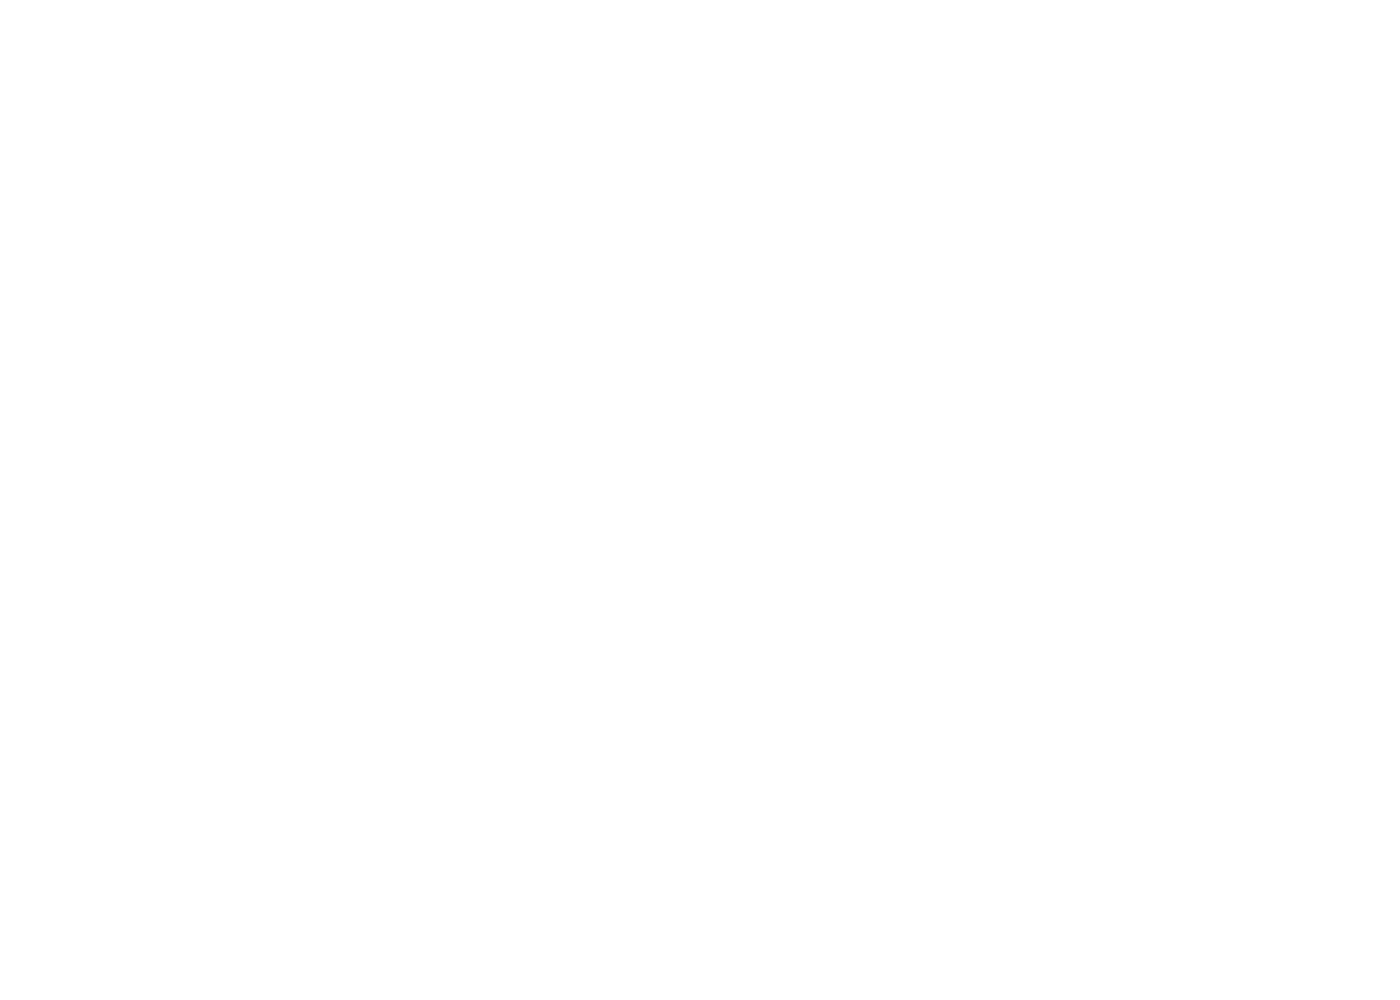

In [19]:
plt.rcParams["figure.figsize"] = (7, 5)
plot_all_static(objectss, intens, 'max', vminn, vmaxx, True, ccode, 2)


<IPython.core.display.Javascript object>


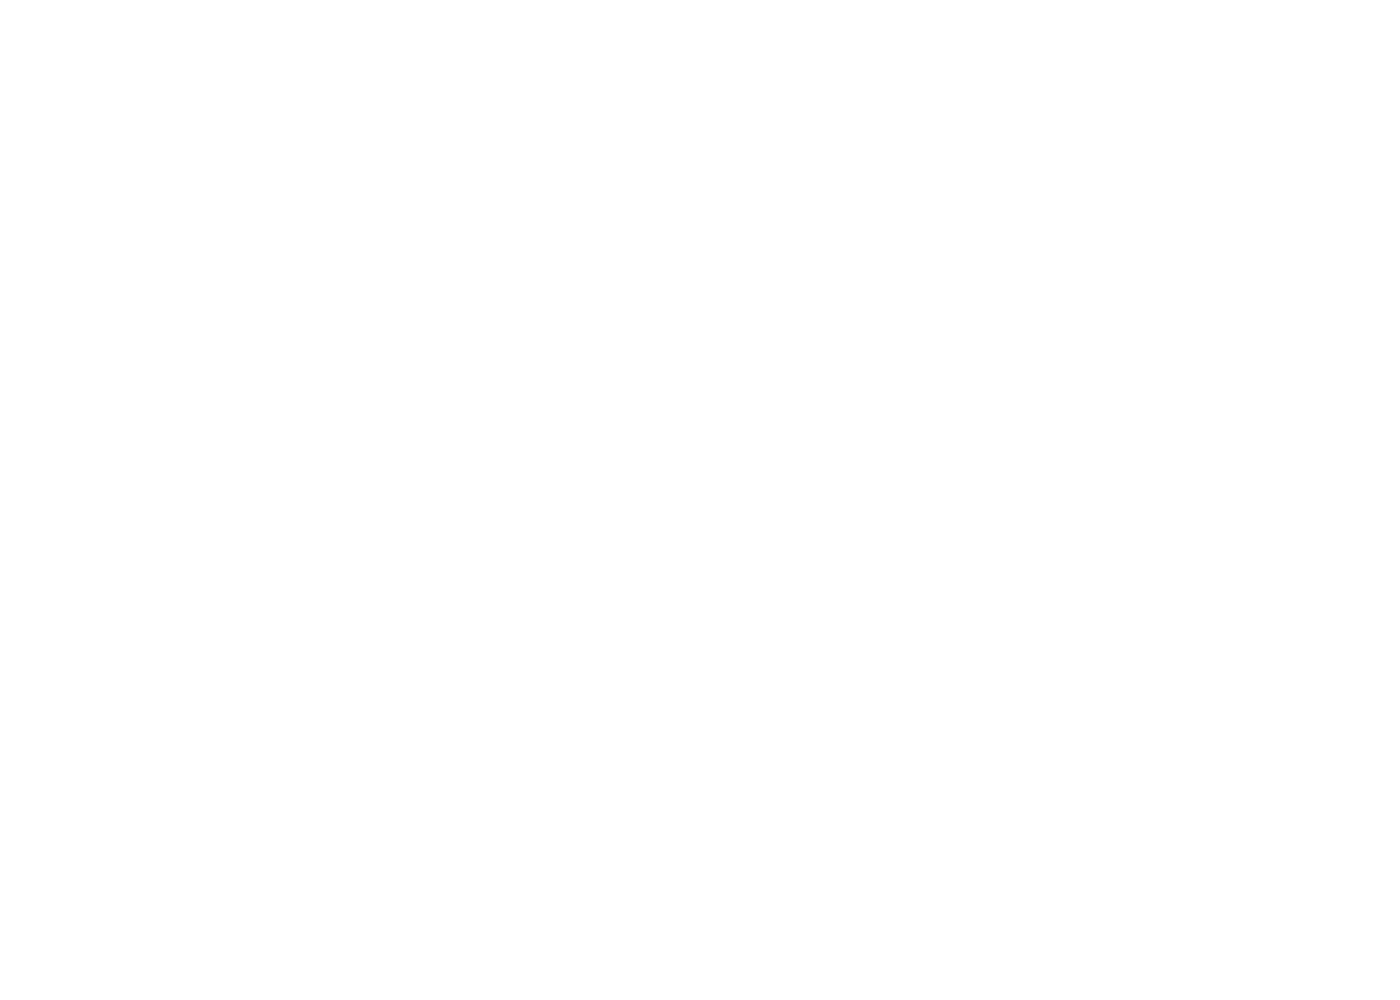

In [18]:
plt.rcParams["figure.figsize"] = (7, 5)
plot_all_invivo(objectss, intens, vminn, vmaxx, True, ccode, 2)


<IPython.core.display.Javascript object>


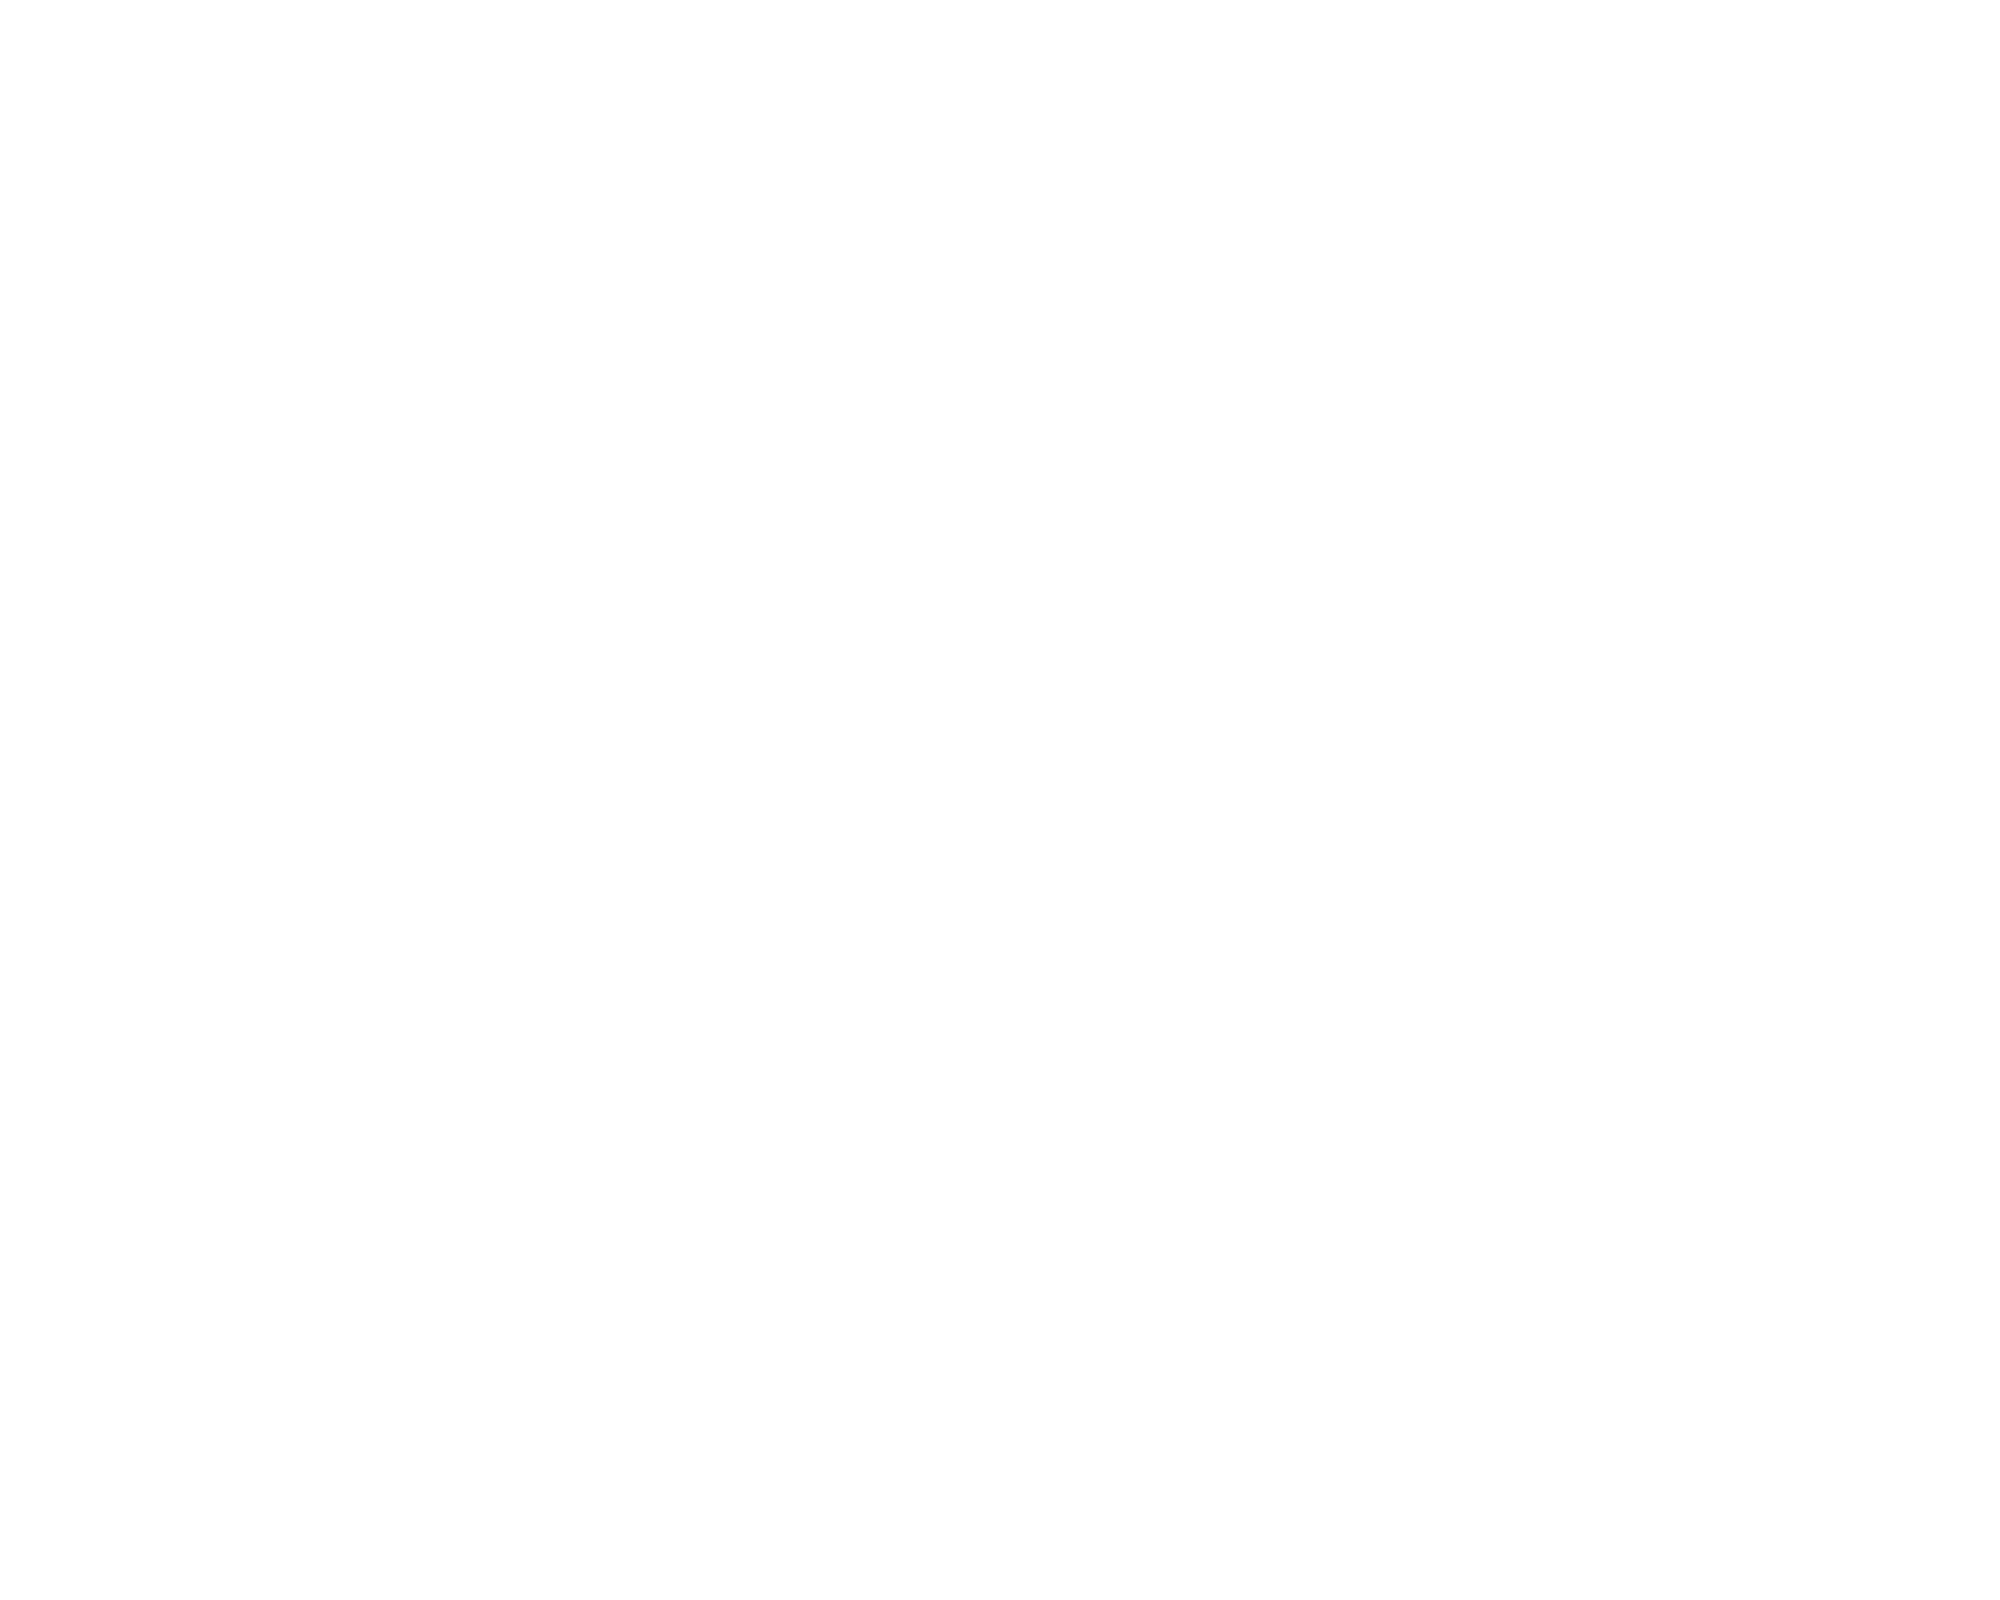

<IPython.core.display.Javascript object>


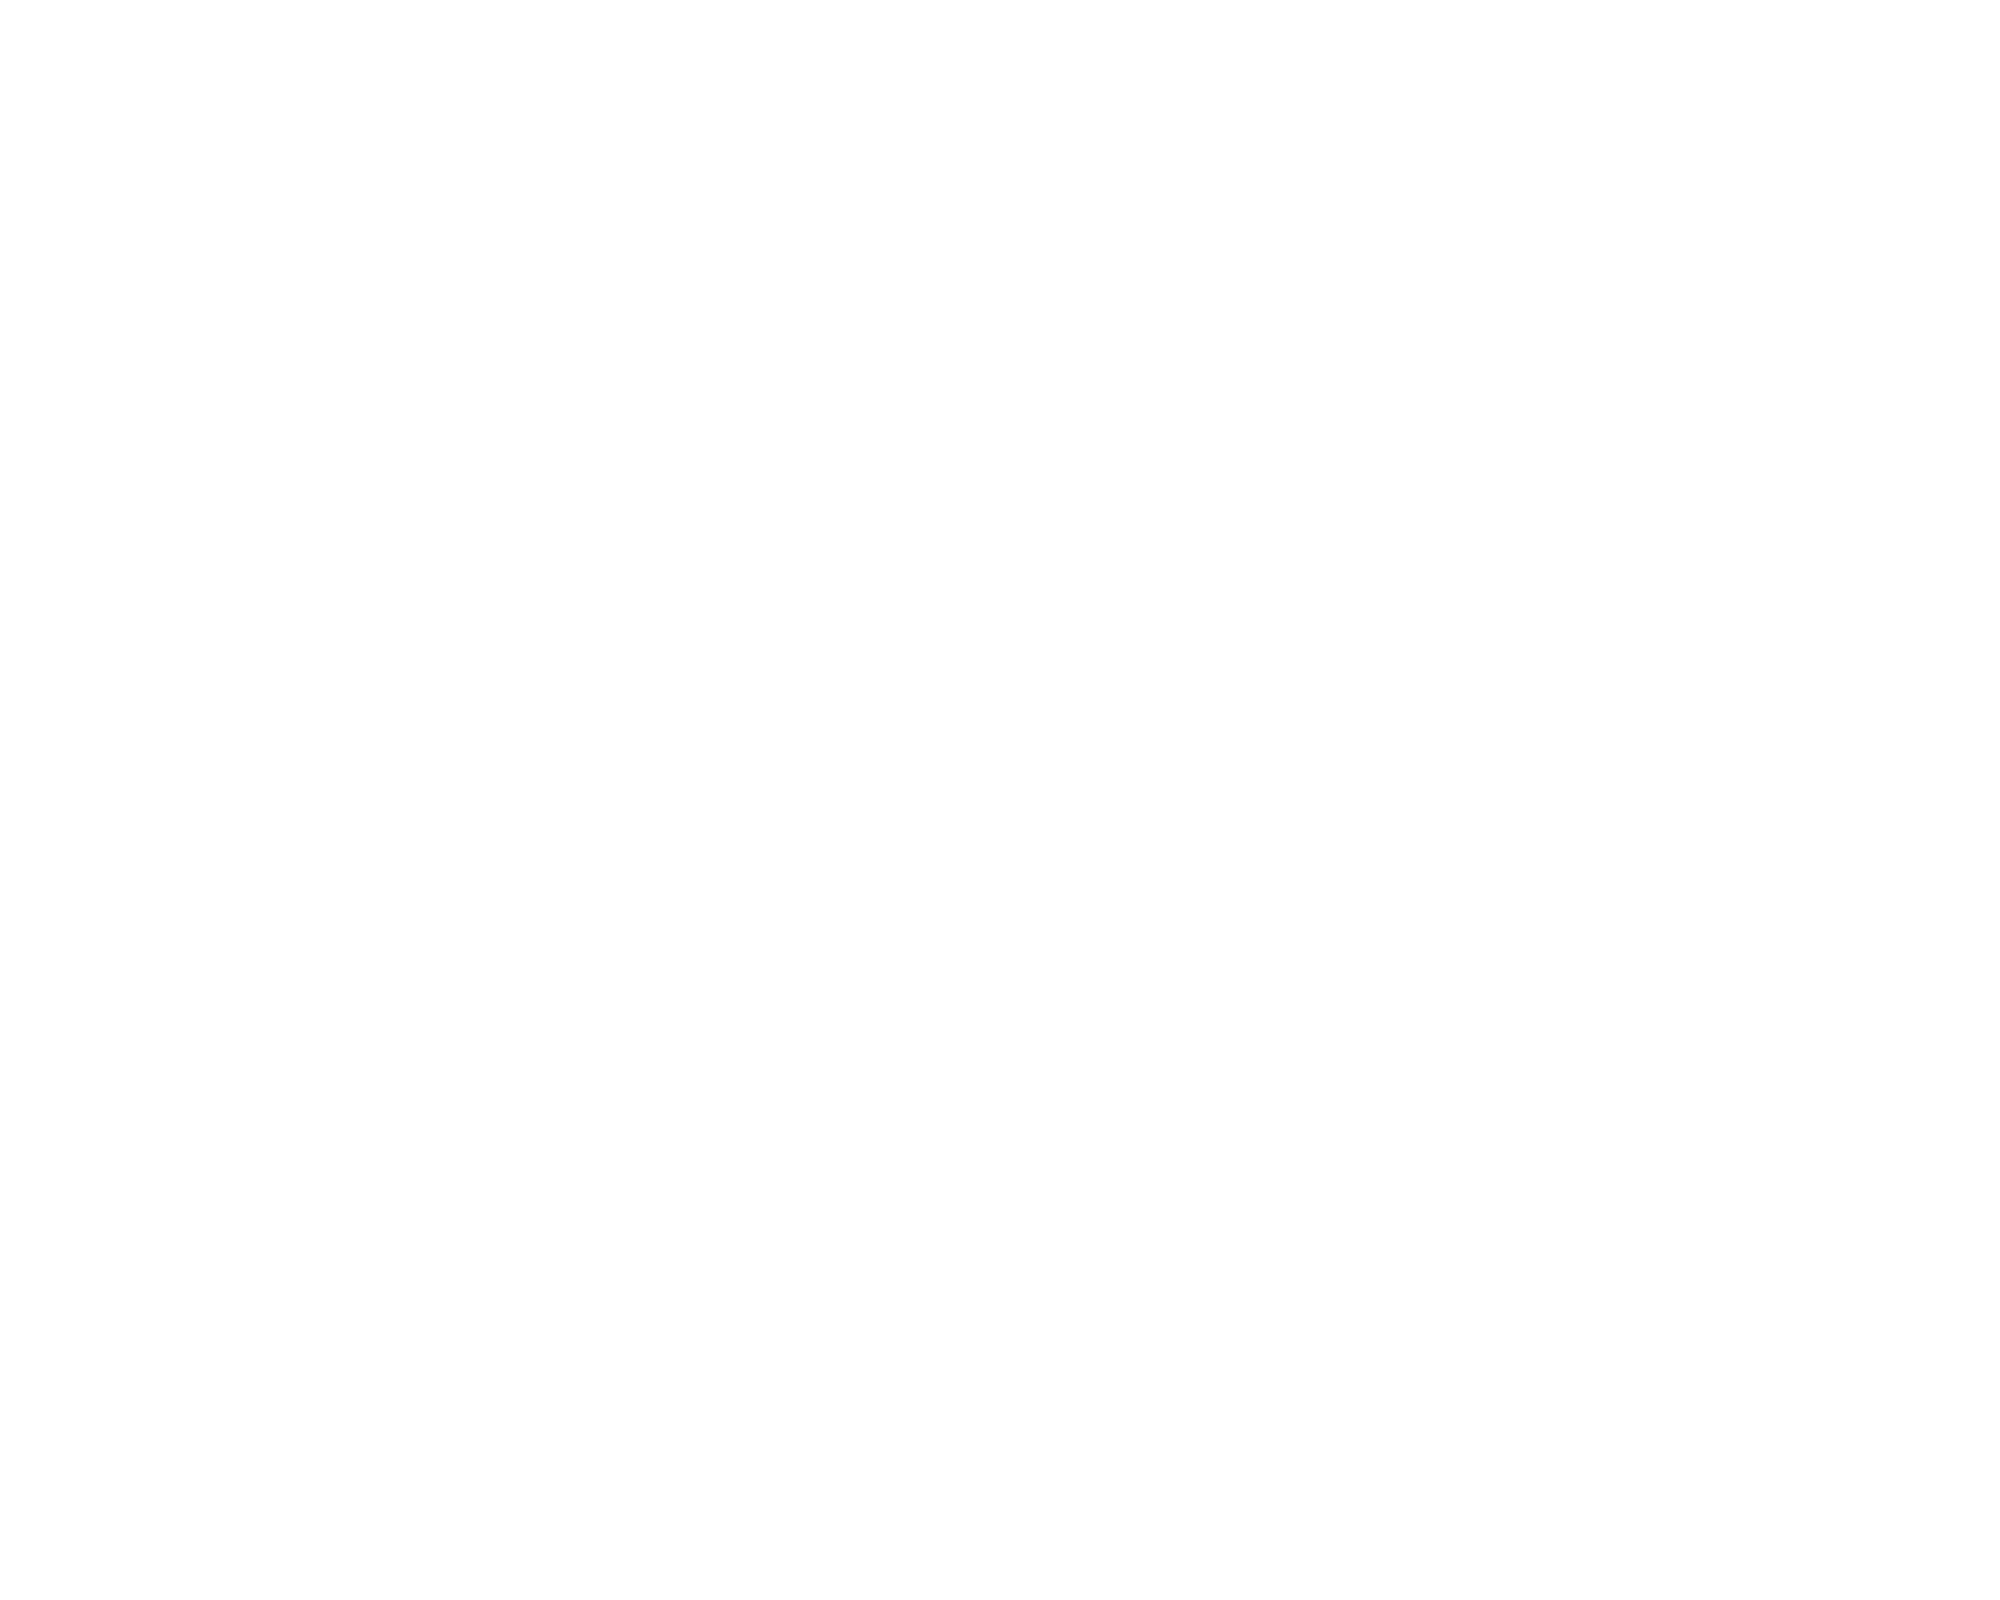

<IPython.core.display.Javascript object>


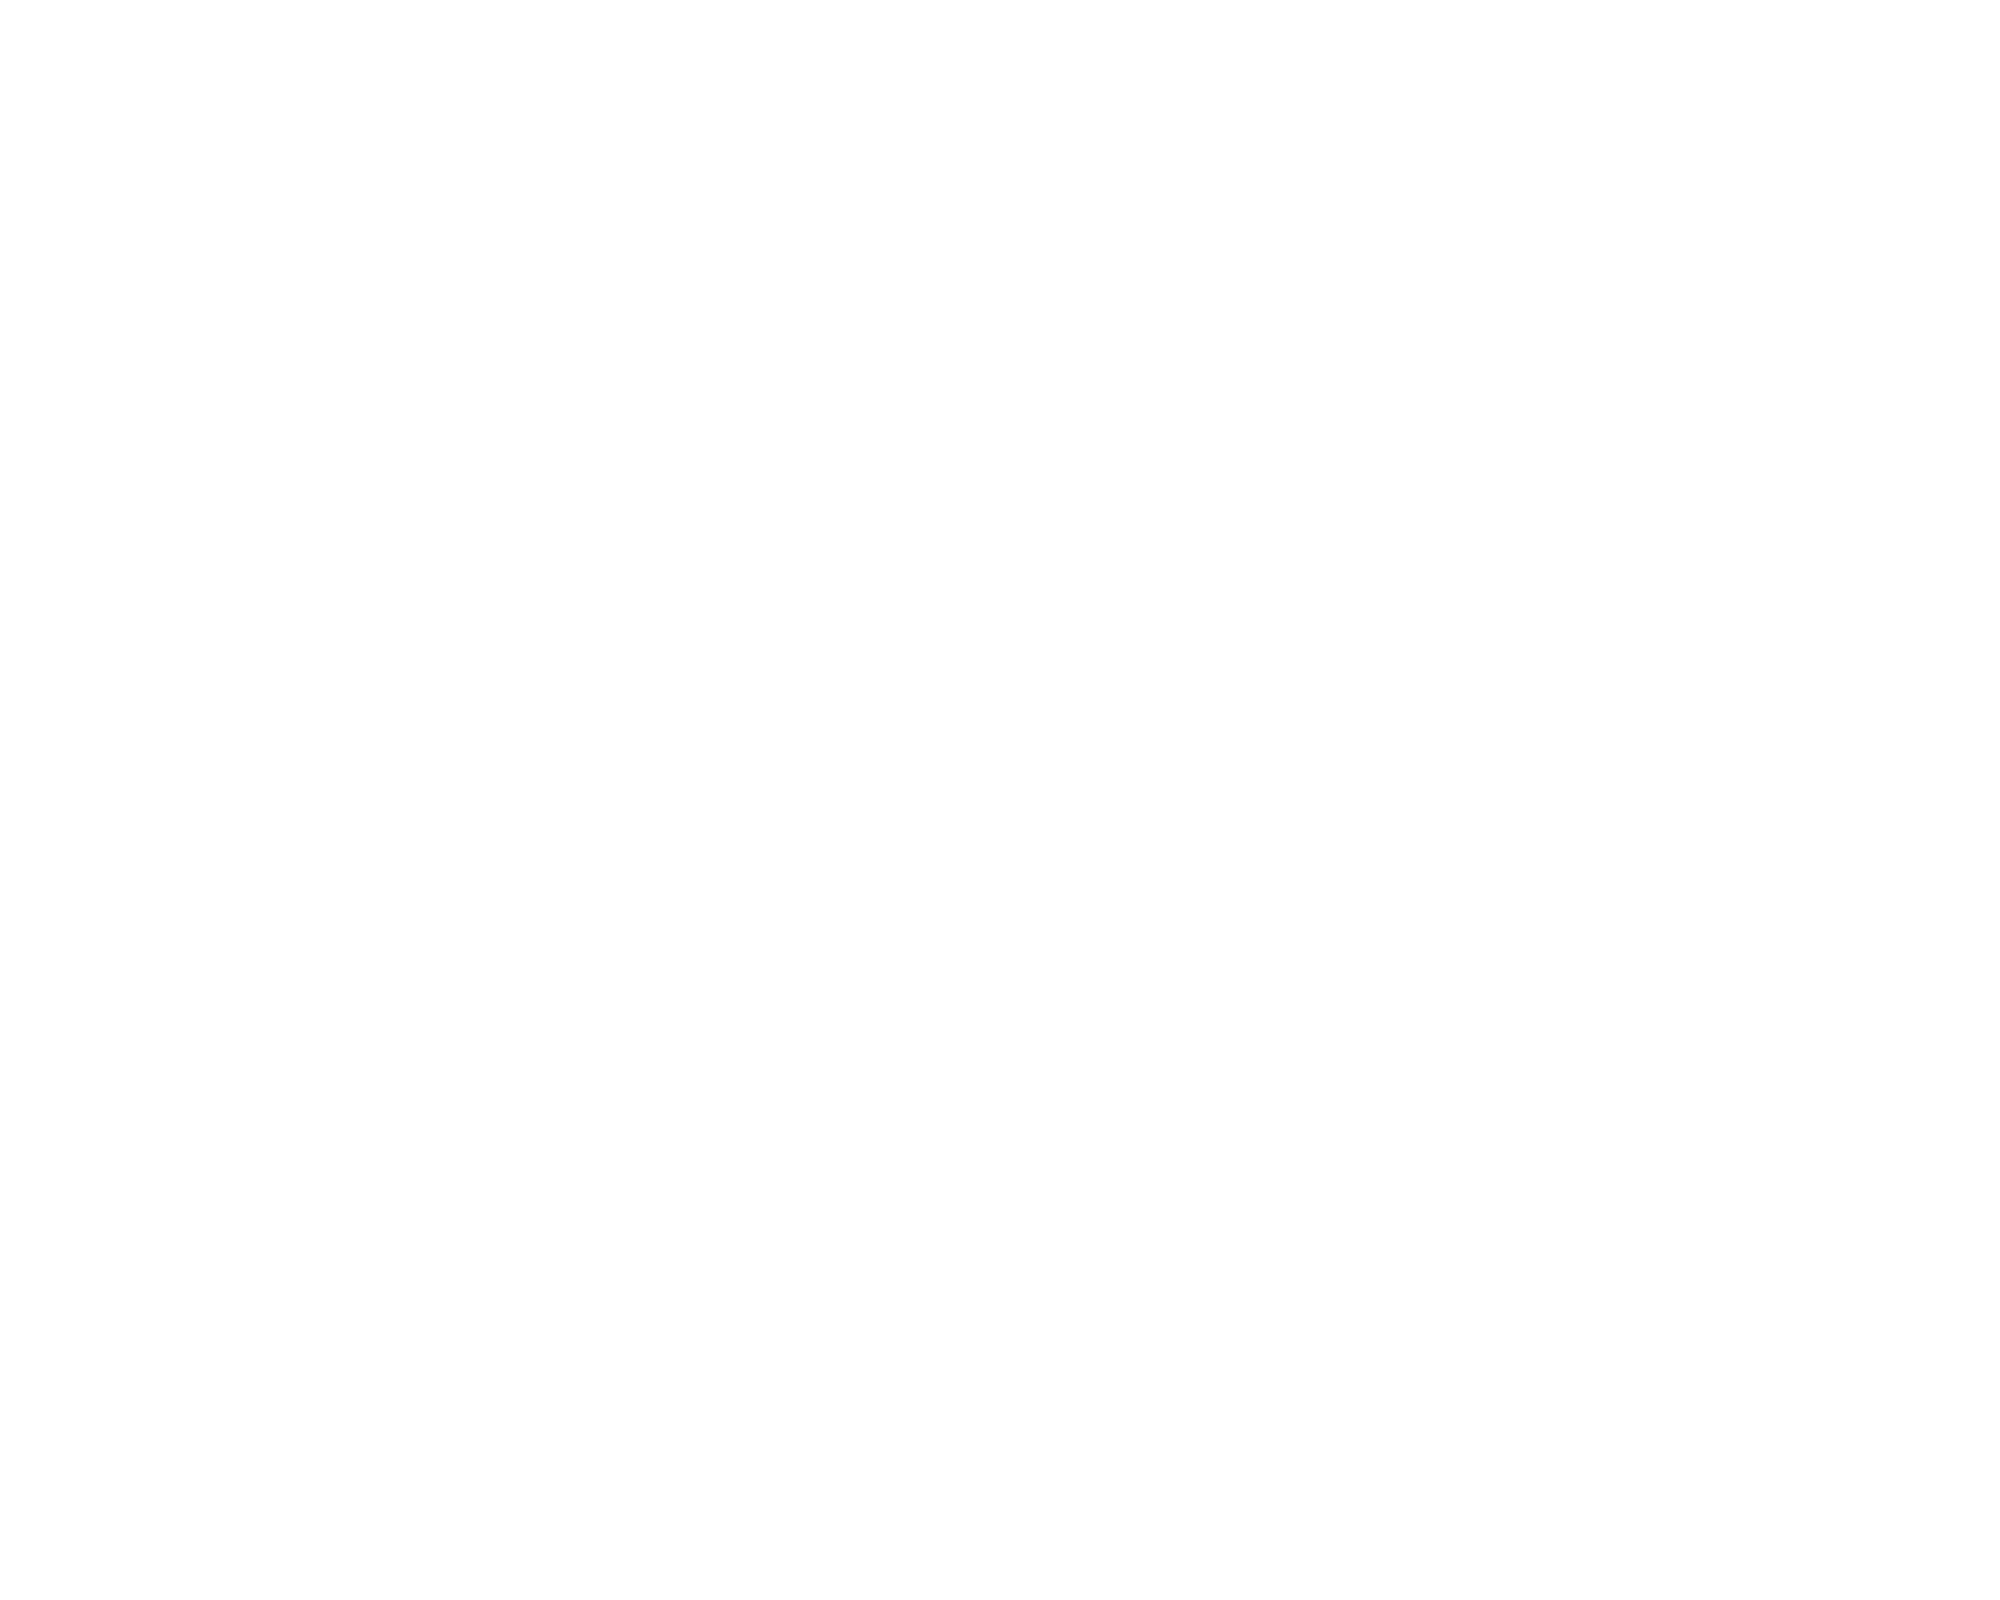

<IPython.core.display.Javascript object>


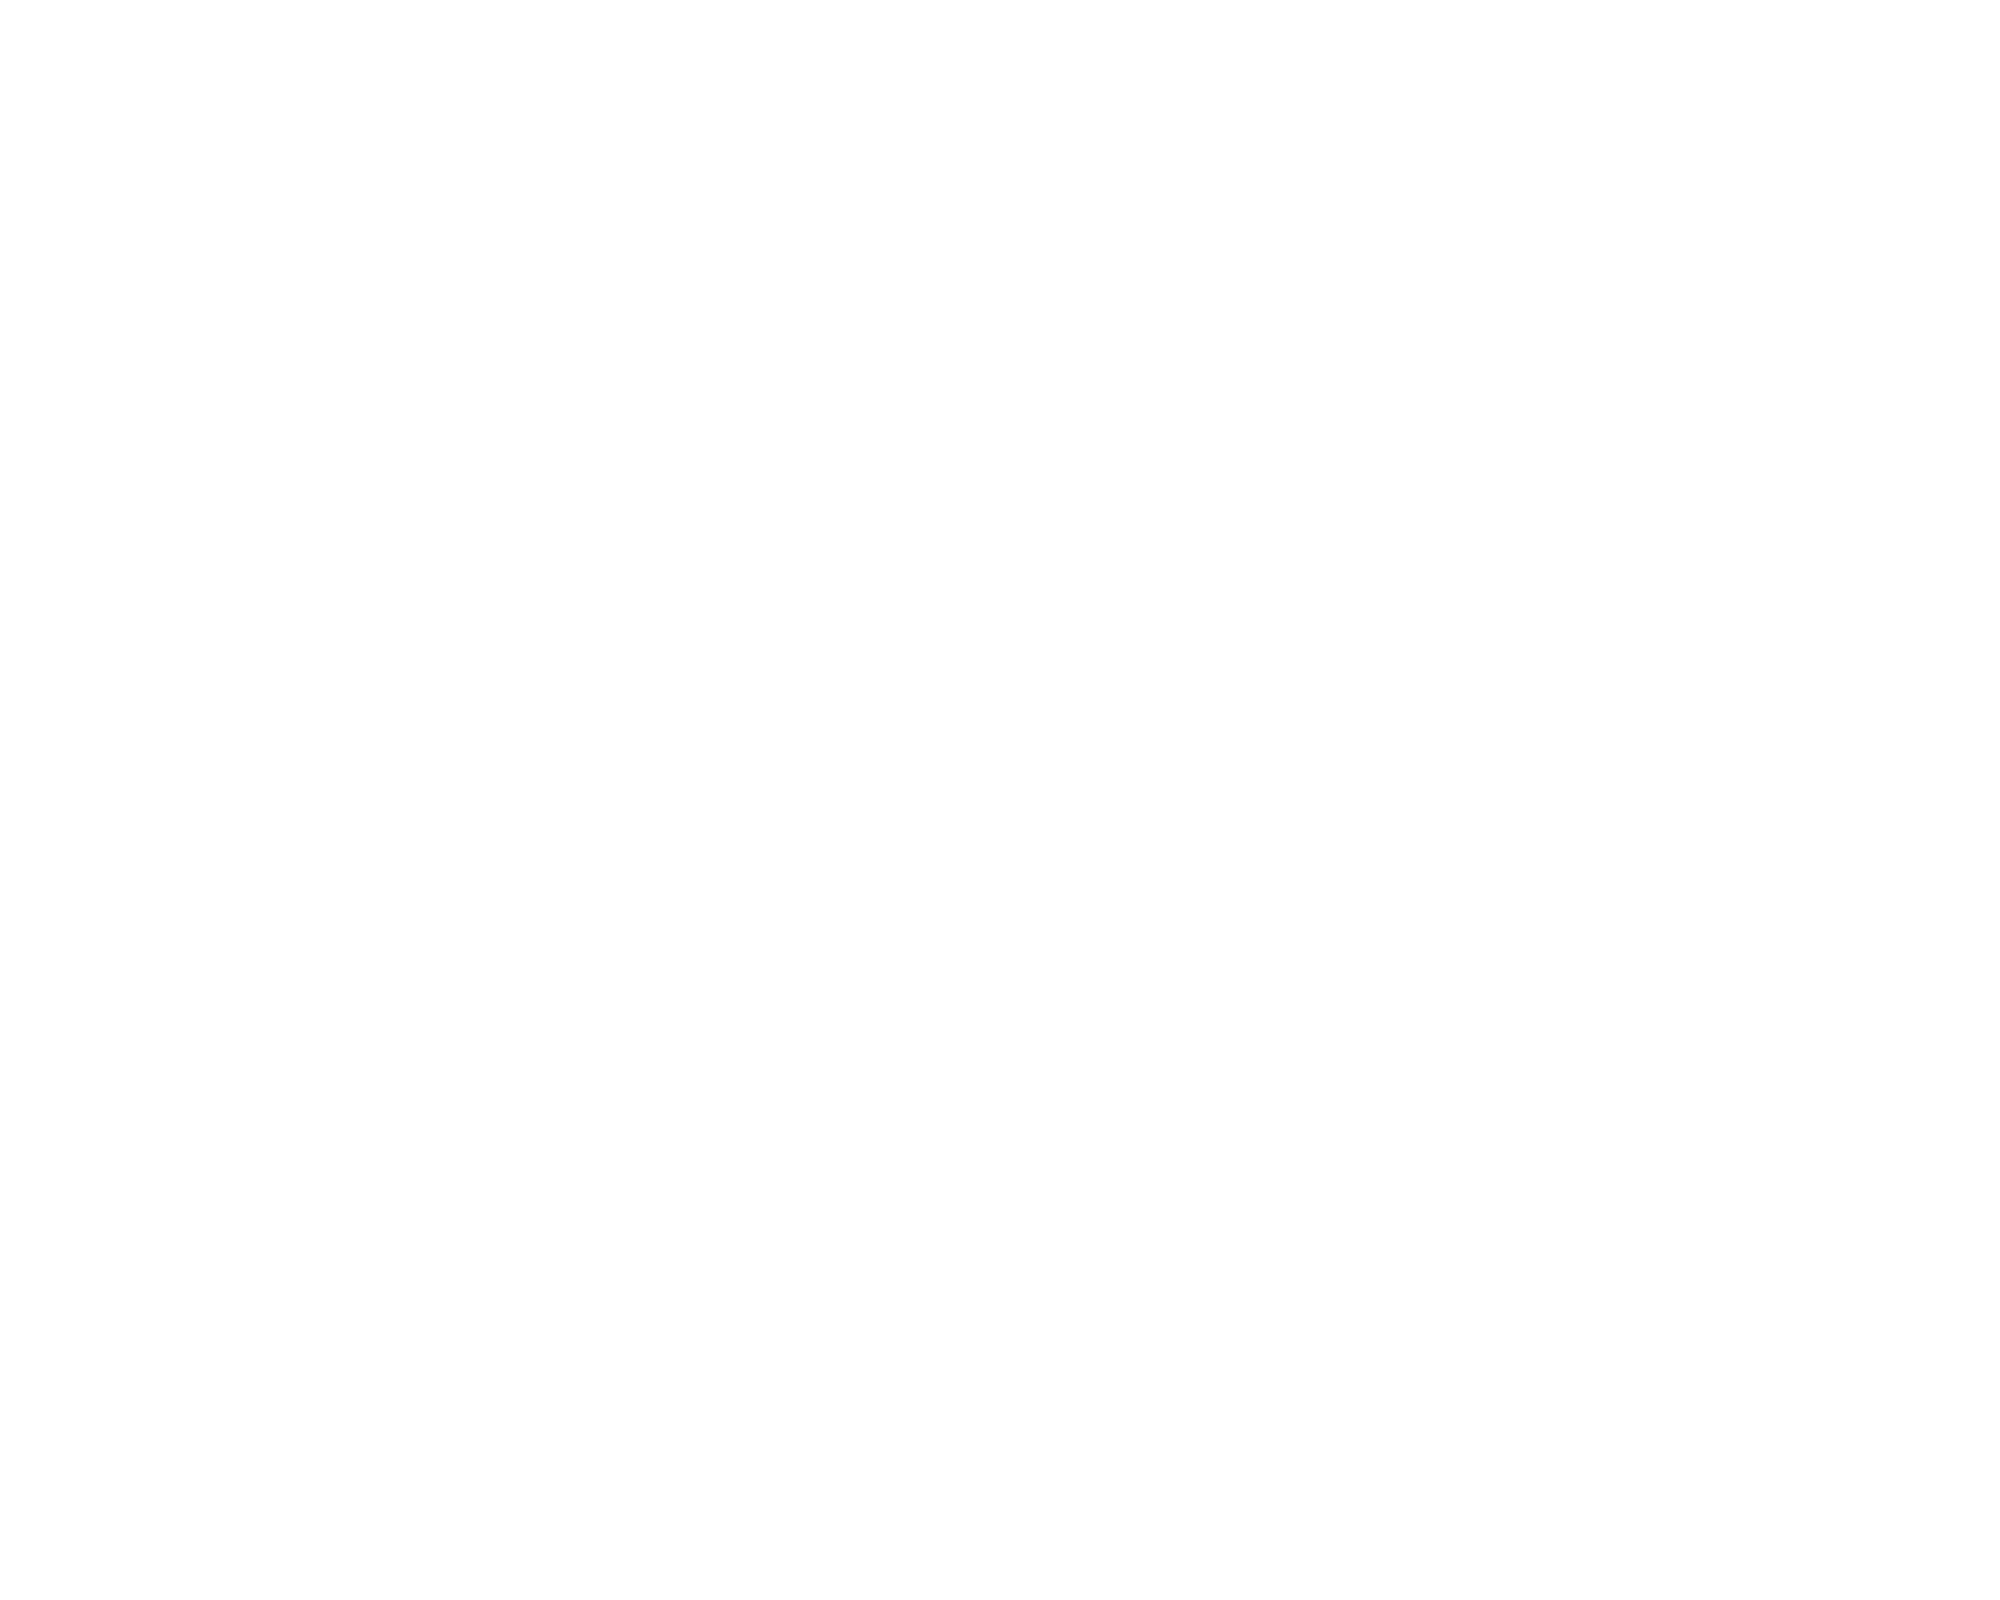

<IPython.core.display.Javascript object>


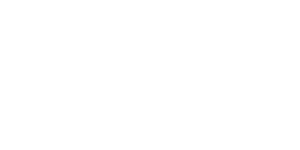

<IPython.core.display.Javascript object>


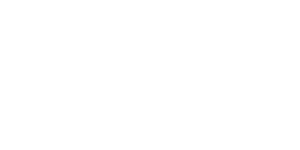

<IPython.core.display.Javascript object>


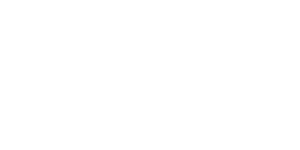

<IPython.core.display.Javascript object>


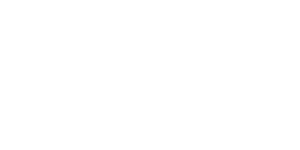

<IPython.core.display.Javascript object>


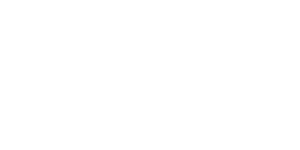

<IPython.core.display.Javascript object>


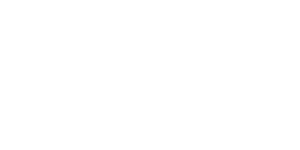

<IPython.core.display.Javascript object>


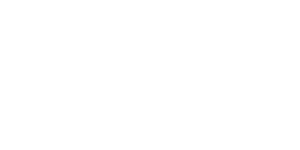

<IPython.core.display.Javascript object>


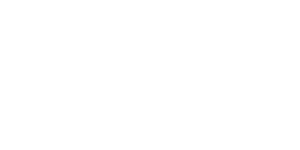

<IPython.core.display.Javascript object>


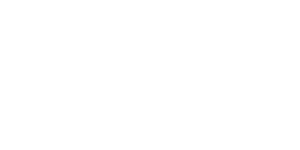

<IPython.core.display.Javascript object>


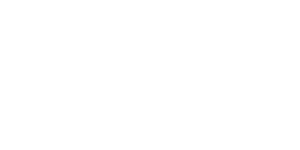

<IPython.core.display.Javascript object>


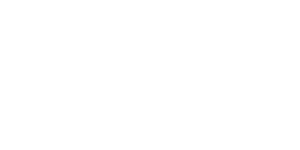

<IPython.core.display.Javascript object>


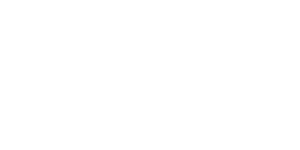

<IPython.core.display.Javascript object>


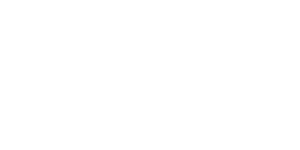

C:\Users\lukas\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:181: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
C:\Users\lukas\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:195: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\lukas\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:198: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


<IPython.core.display.Javascript object>


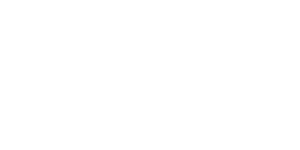

<IPython.core.display.Javascript object>


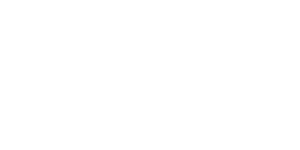

<IPython.core.display.Javascript object>


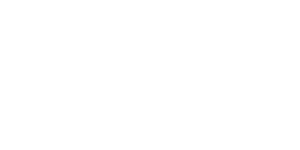

<IPython.core.display.Javascript object>


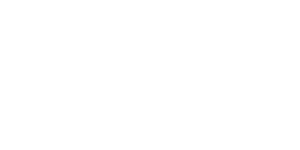

<IPython.core.display.Javascript object>


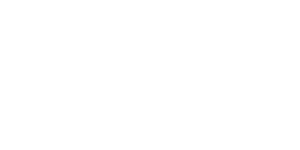

<IPython.core.display.Javascript object>


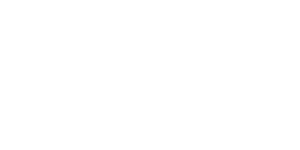

<IPython.core.display.Javascript object>


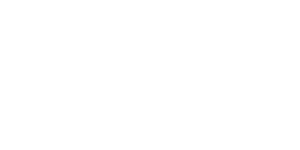

<IPython.core.display.Javascript object>


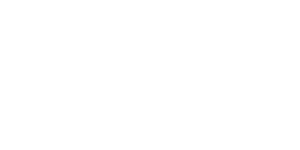

<IPython.core.display.Javascript object>


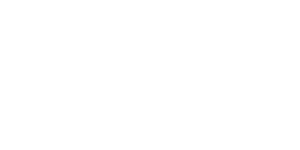

<IPython.core.display.Javascript object>


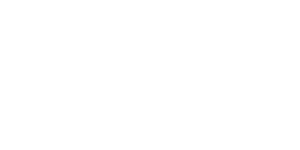

<IPython.core.display.Javascript object>


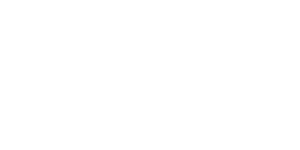

<IPython.core.display.Javascript object>


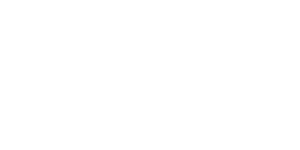

<IPython.core.display.Javascript object>


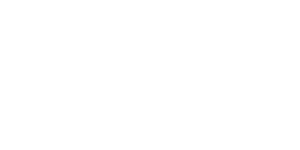

<IPython.core.display.Javascript object>


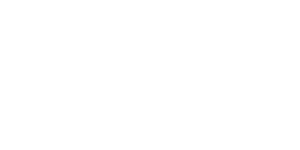

<IPython.core.display.Javascript object>


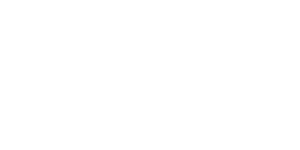

<IPython.core.display.Javascript object>


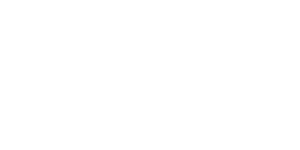

<IPython.core.display.Javascript object>


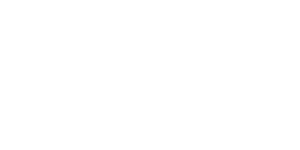

<IPython.core.display.Javascript object>


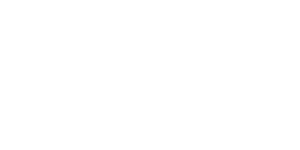

<IPython.core.display.Javascript object>


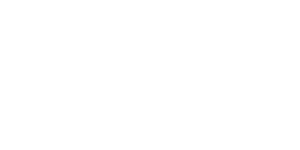

<IPython.core.display.Javascript object>


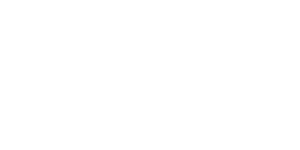

<IPython.core.display.Javascript object>


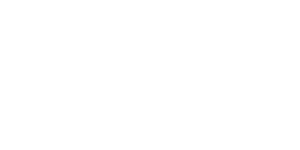

<IPython.core.display.Javascript object>


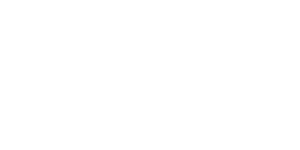

<IPython.core.display.Javascript object>


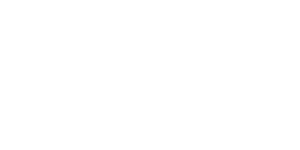

<IPython.core.display.Javascript object>


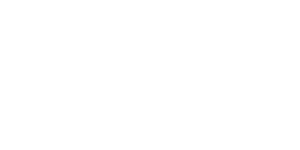

<IPython.core.display.Javascript object>


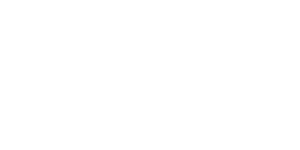

<IPython.core.display.Javascript object>


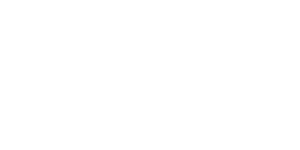

<IPython.core.display.Javascript object>


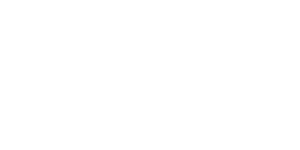

<IPython.core.display.Javascript object>


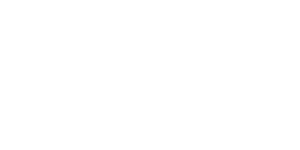

<IPython.core.display.Javascript object>


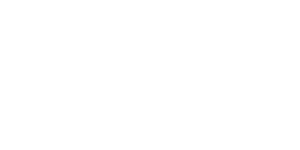

<IPython.core.display.Javascript object>


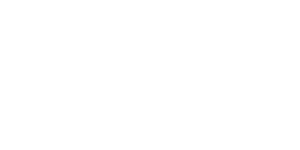

<IPython.core.display.Javascript object>


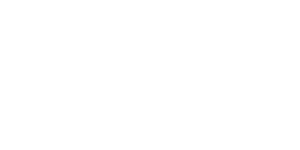

<IPython.core.display.Javascript object>


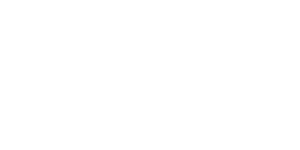

<IPython.core.display.Javascript object>


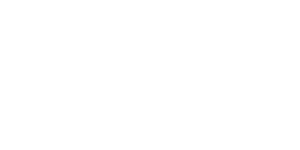

<IPython.core.display.Javascript object>


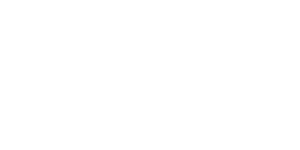

<IPython.core.display.Javascript object>


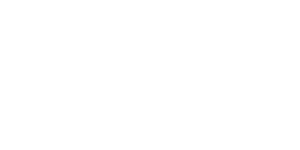

<IPython.core.display.Javascript object>


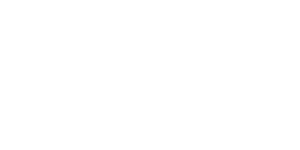

<IPython.core.display.Javascript object>


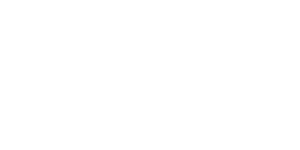

<IPython.core.display.Javascript object>


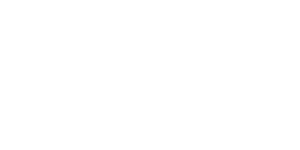

<IPython.core.display.Javascript object>


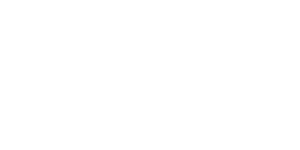

<IPython.core.display.Javascript object>


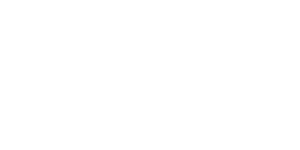

<IPython.core.display.Javascript object>


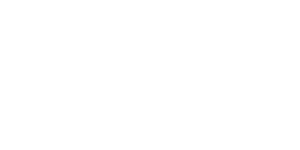

<IPython.core.display.Javascript object>


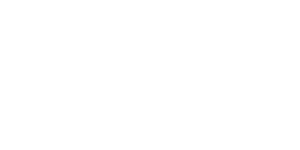

<IPython.core.display.Javascript object>


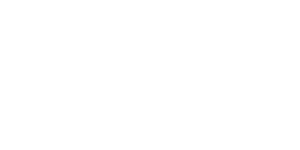

<IPython.core.display.Javascript object>


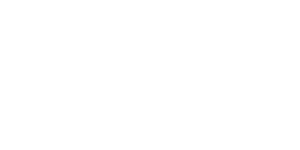

<IPython.core.display.Javascript object>


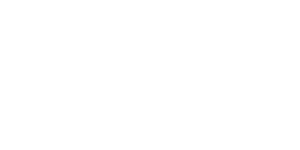

<IPython.core.display.Javascript object>


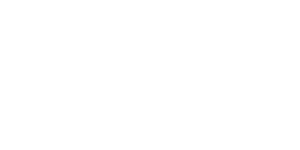

<IPython.core.display.Javascript object>


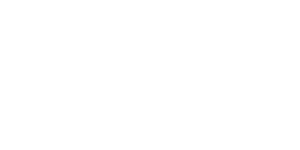

<IPython.core.display.Javascript object>


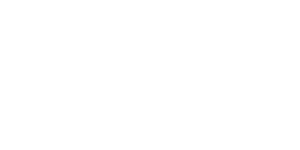

<IPython.core.display.Javascript object>


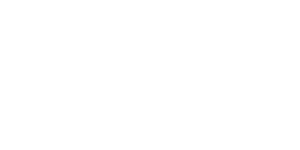

<IPython.core.display.Javascript object>


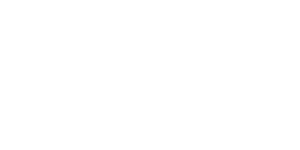

<IPython.core.display.Javascript object>


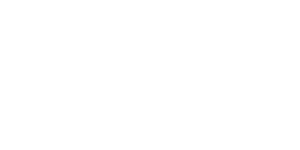

<IPython.core.display.Javascript object>


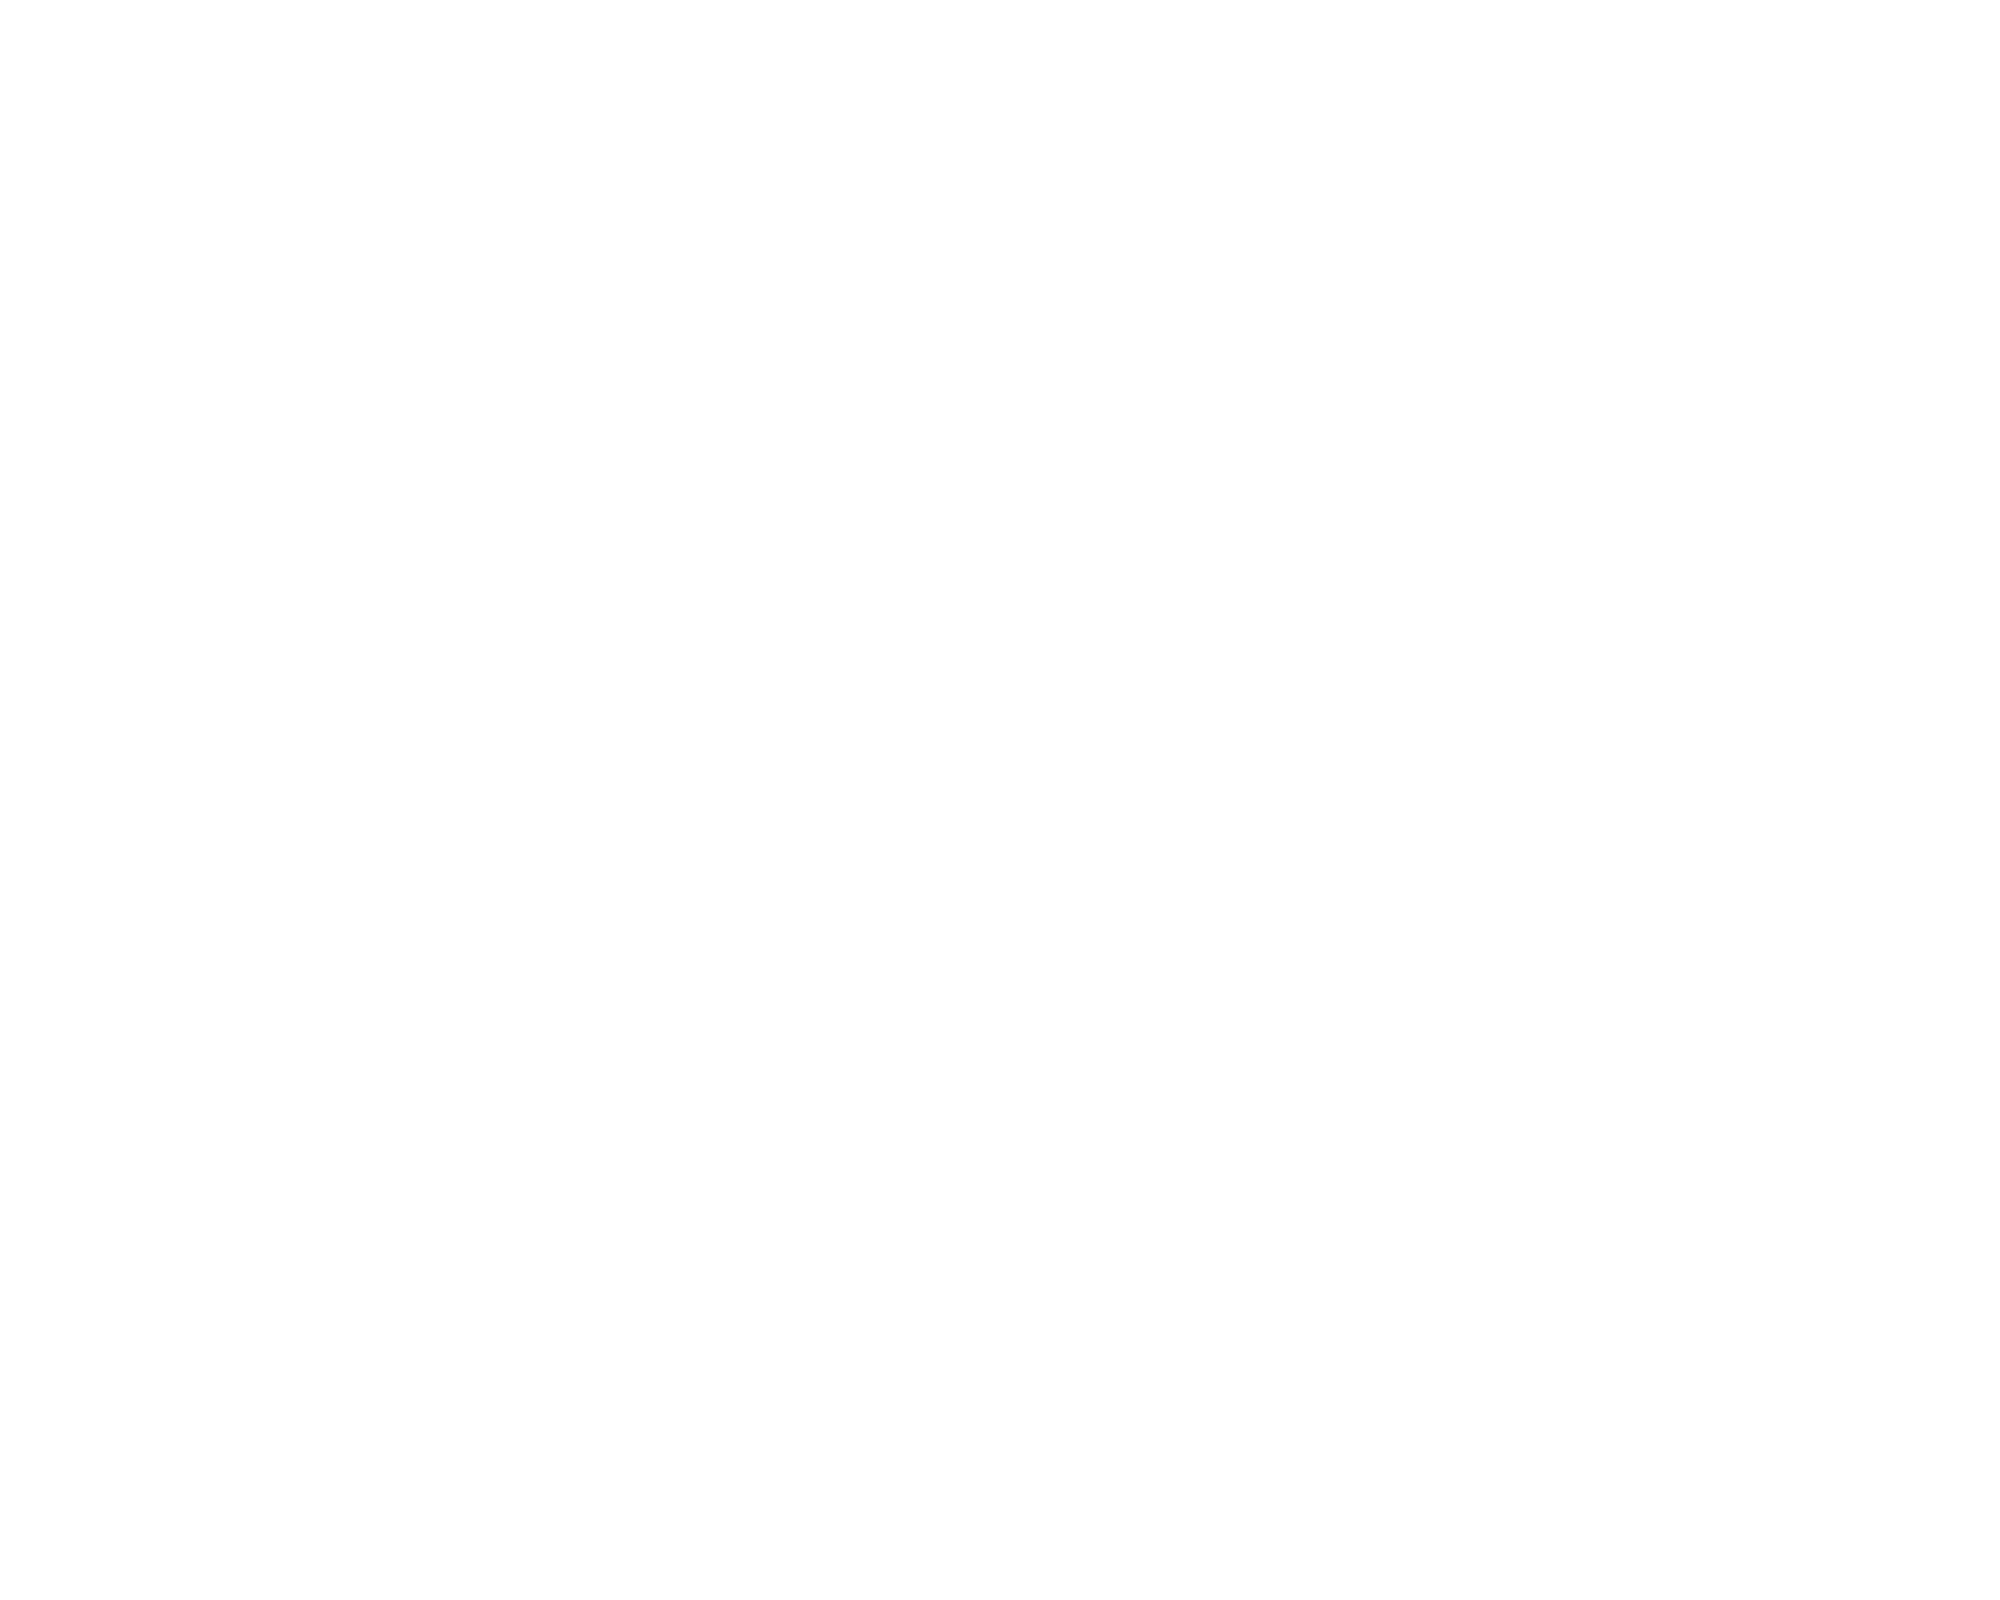

<IPython.core.display.Javascript object>


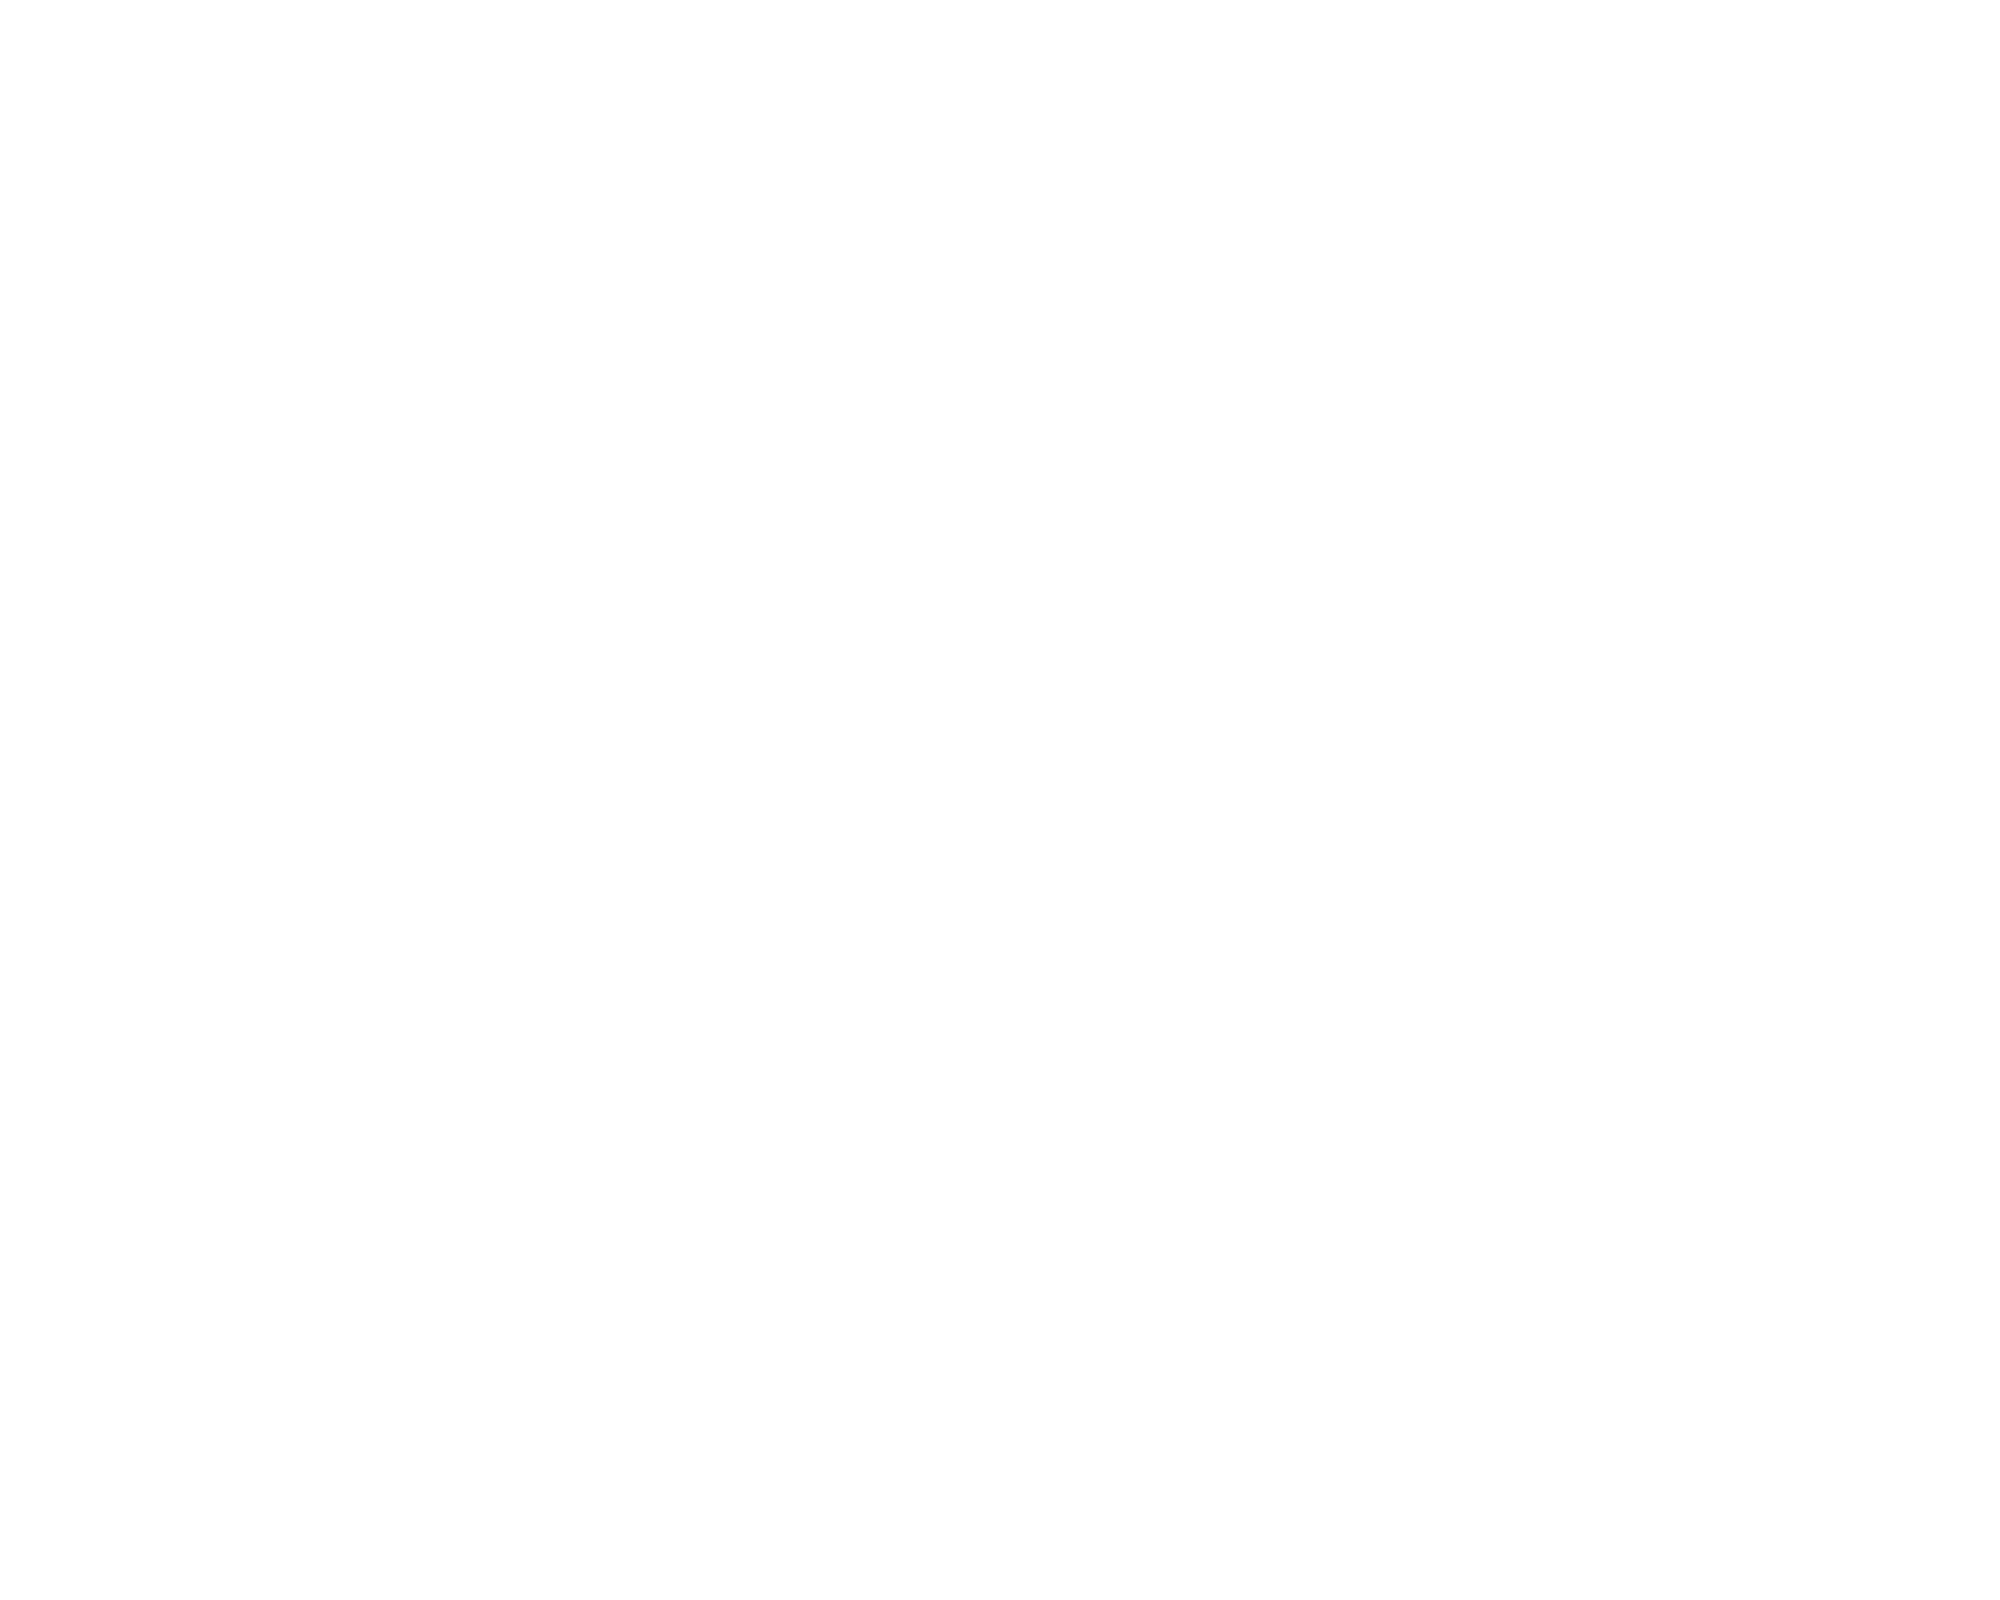

<IPython.core.display.Javascript object>


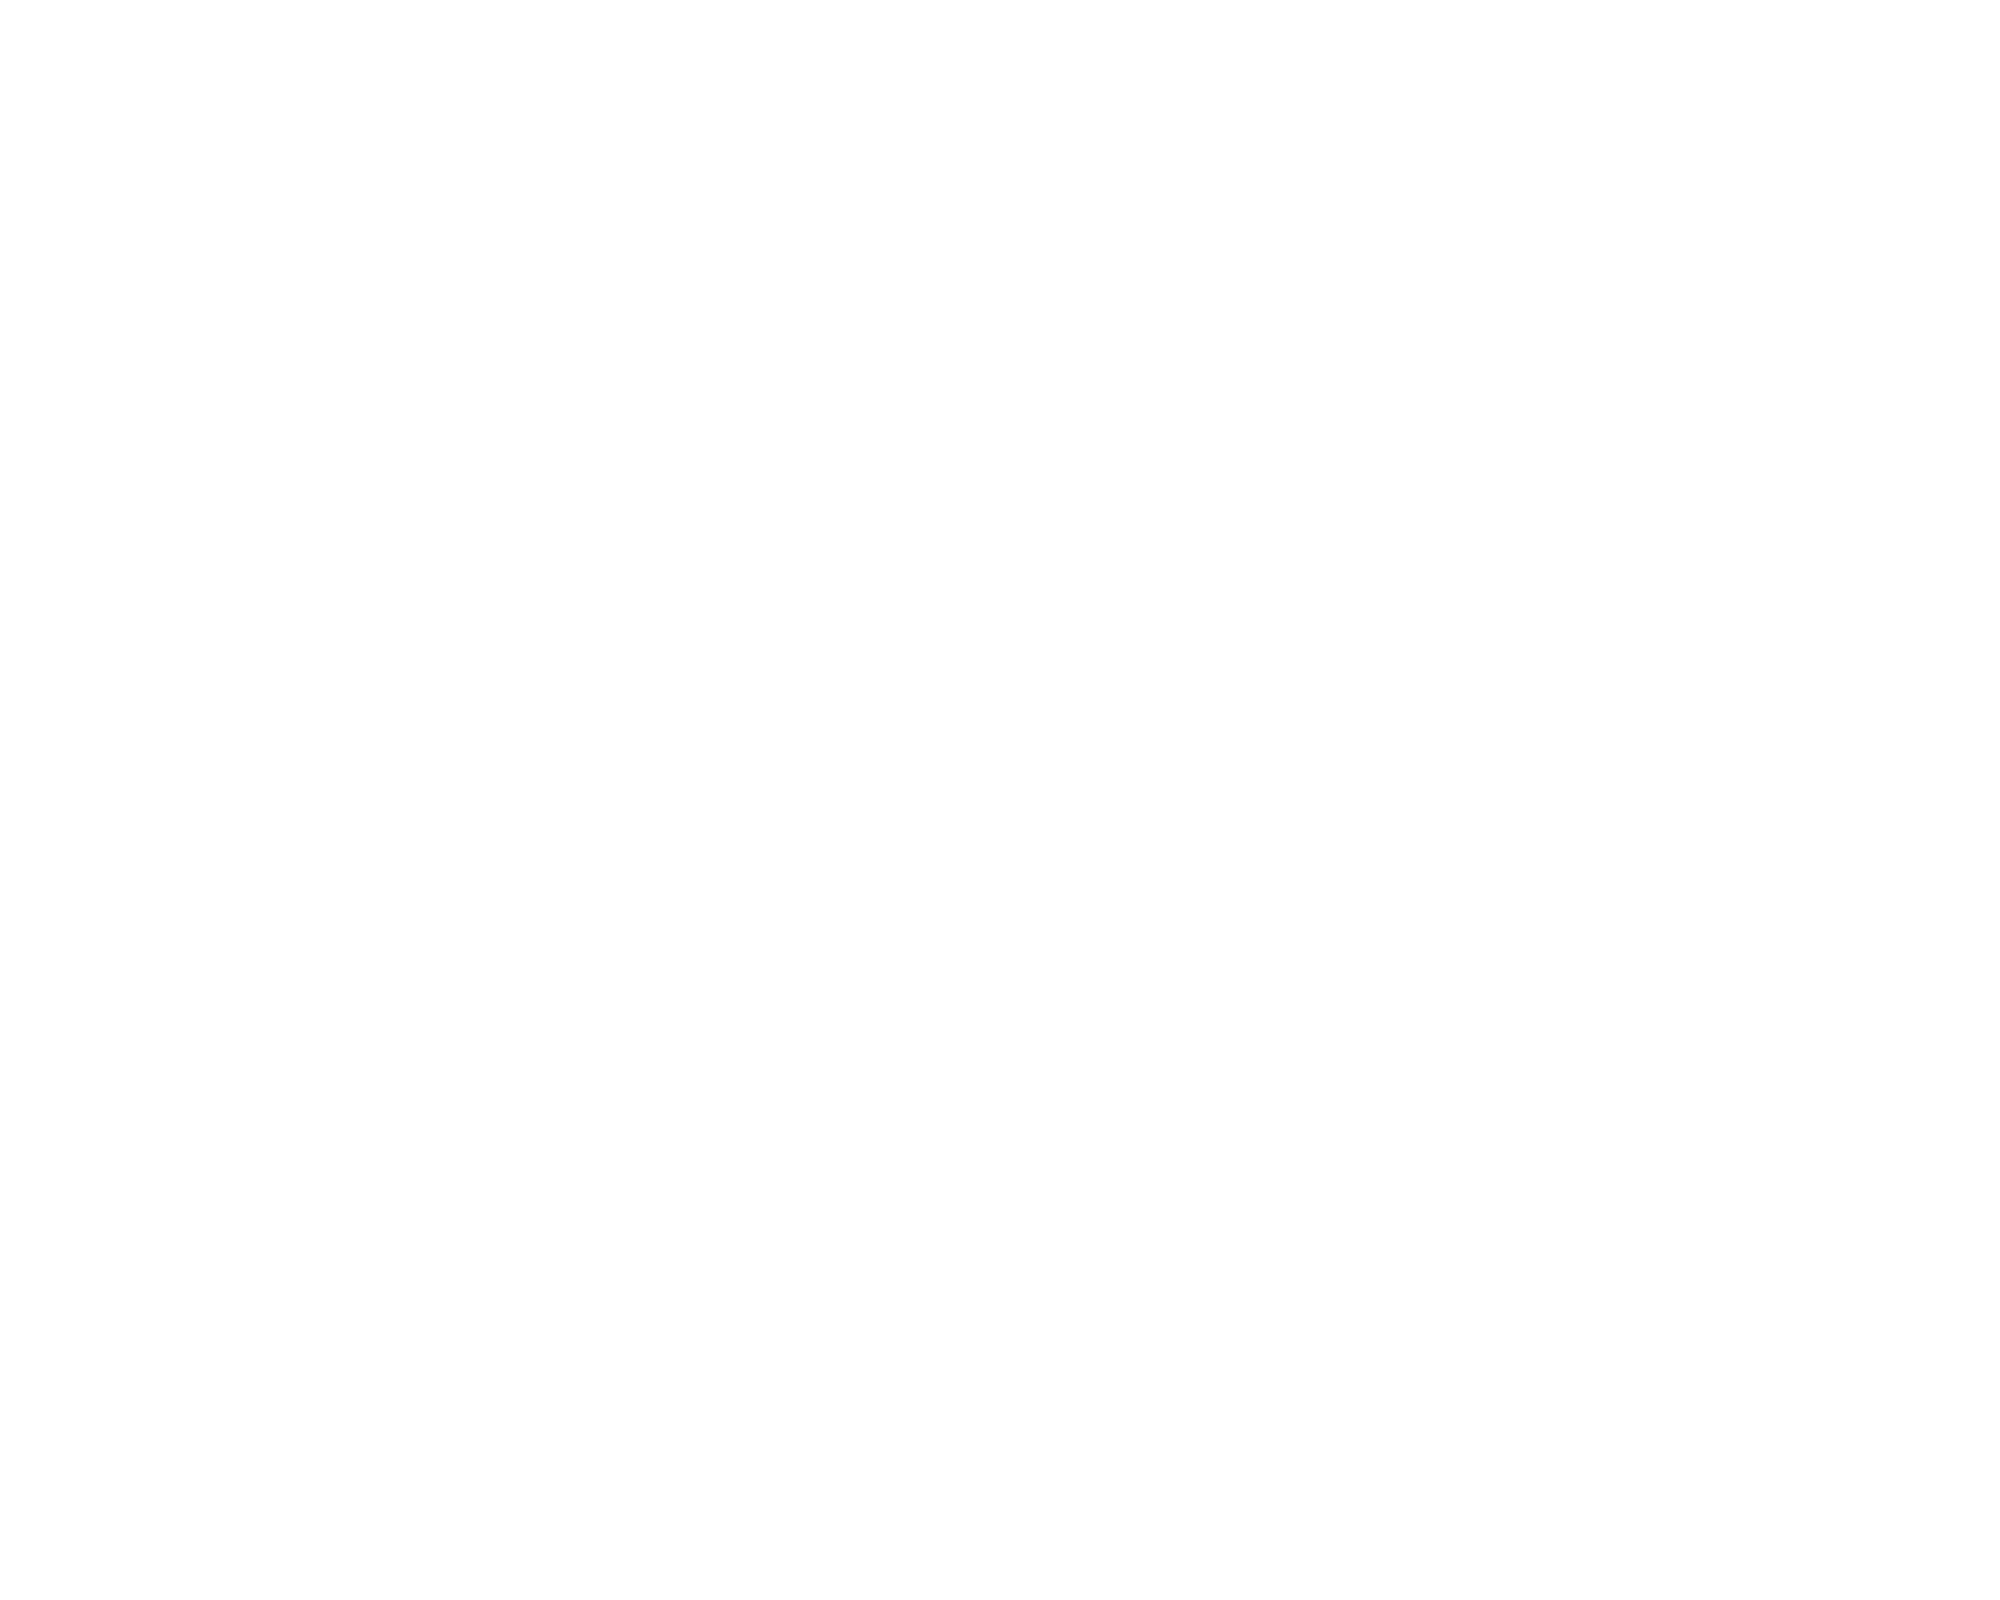

<IPython.core.display.Javascript object>


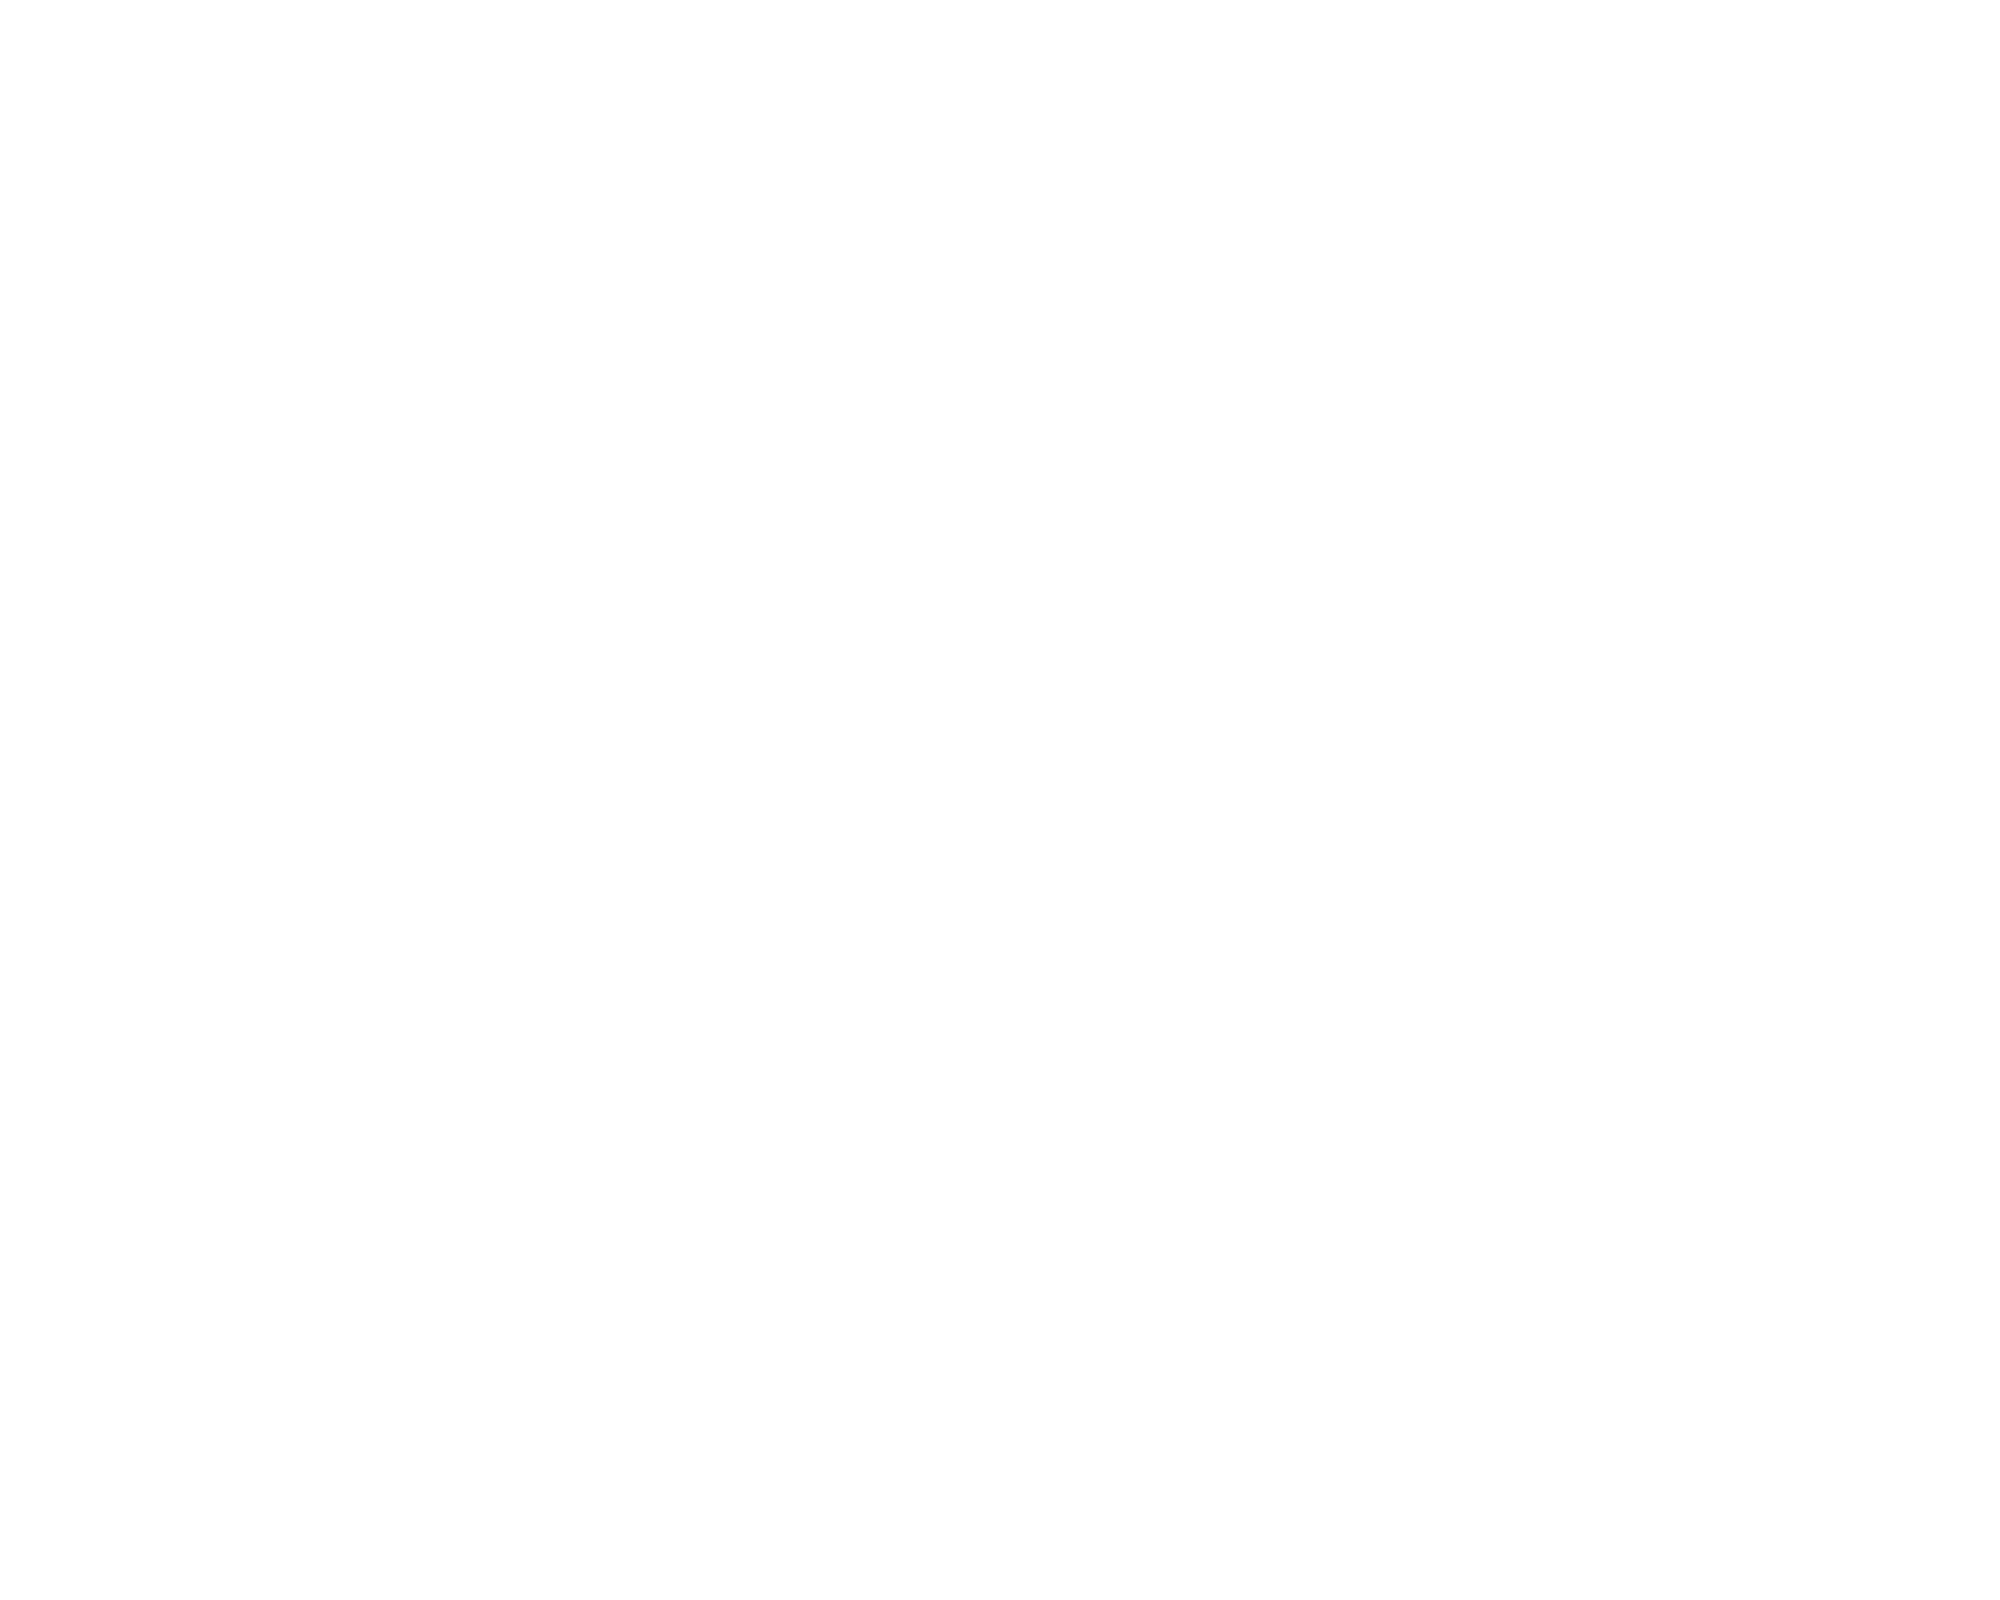

<IPython.core.display.Javascript object>


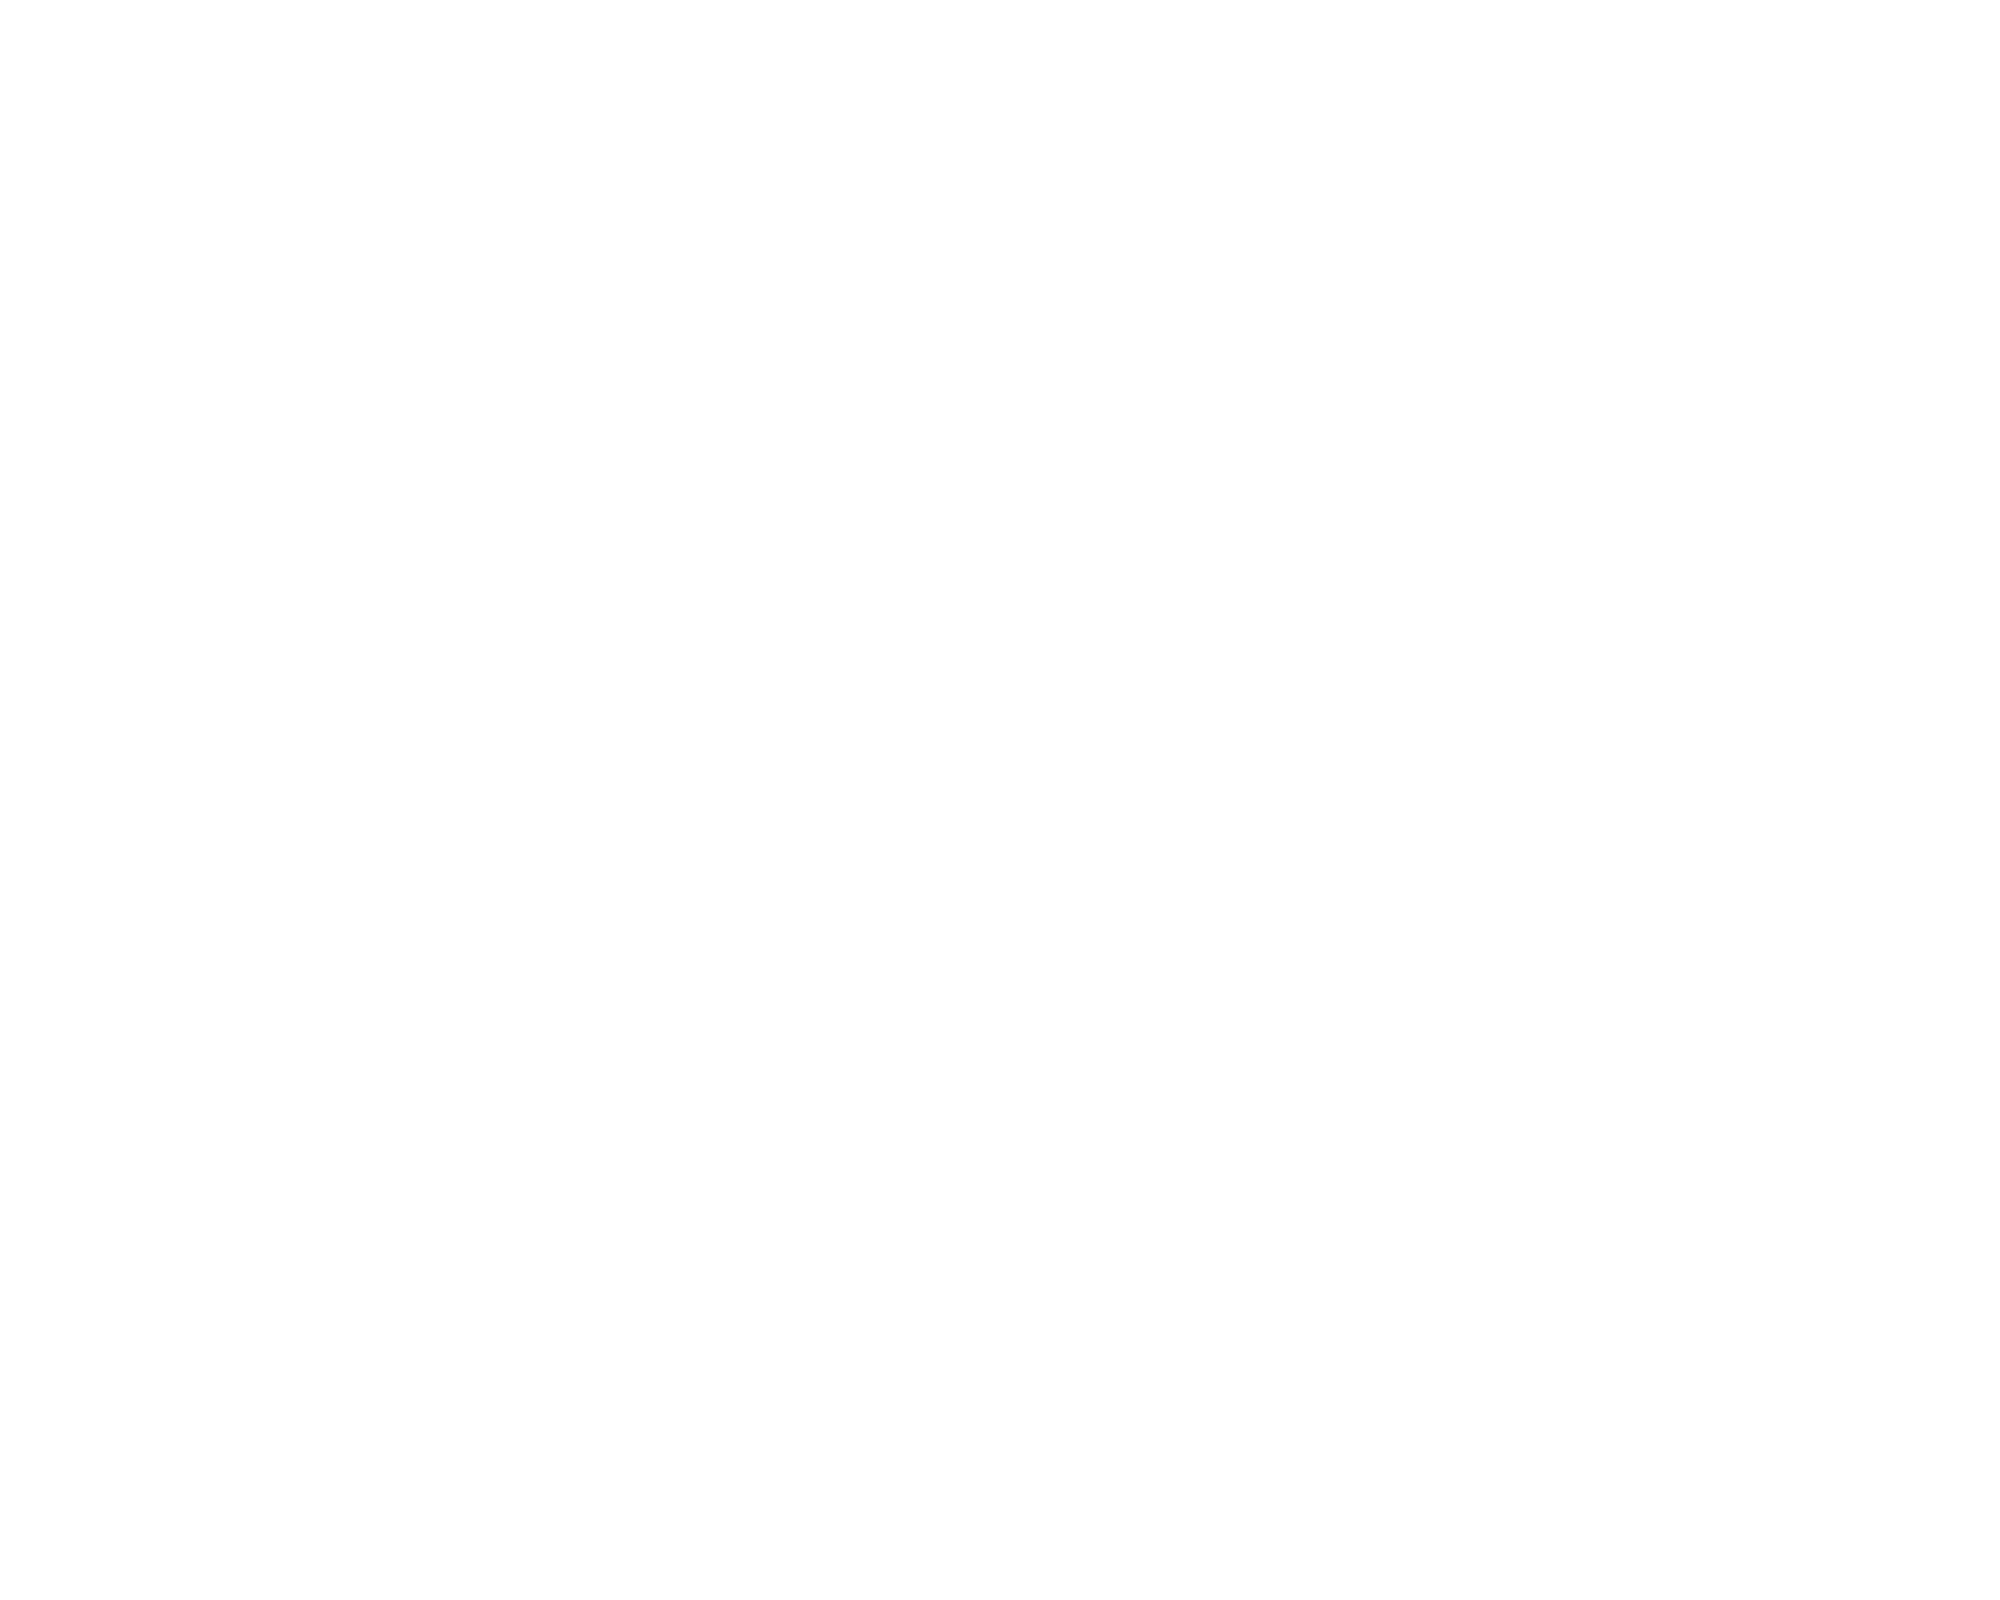

<IPython.core.display.Javascript object>


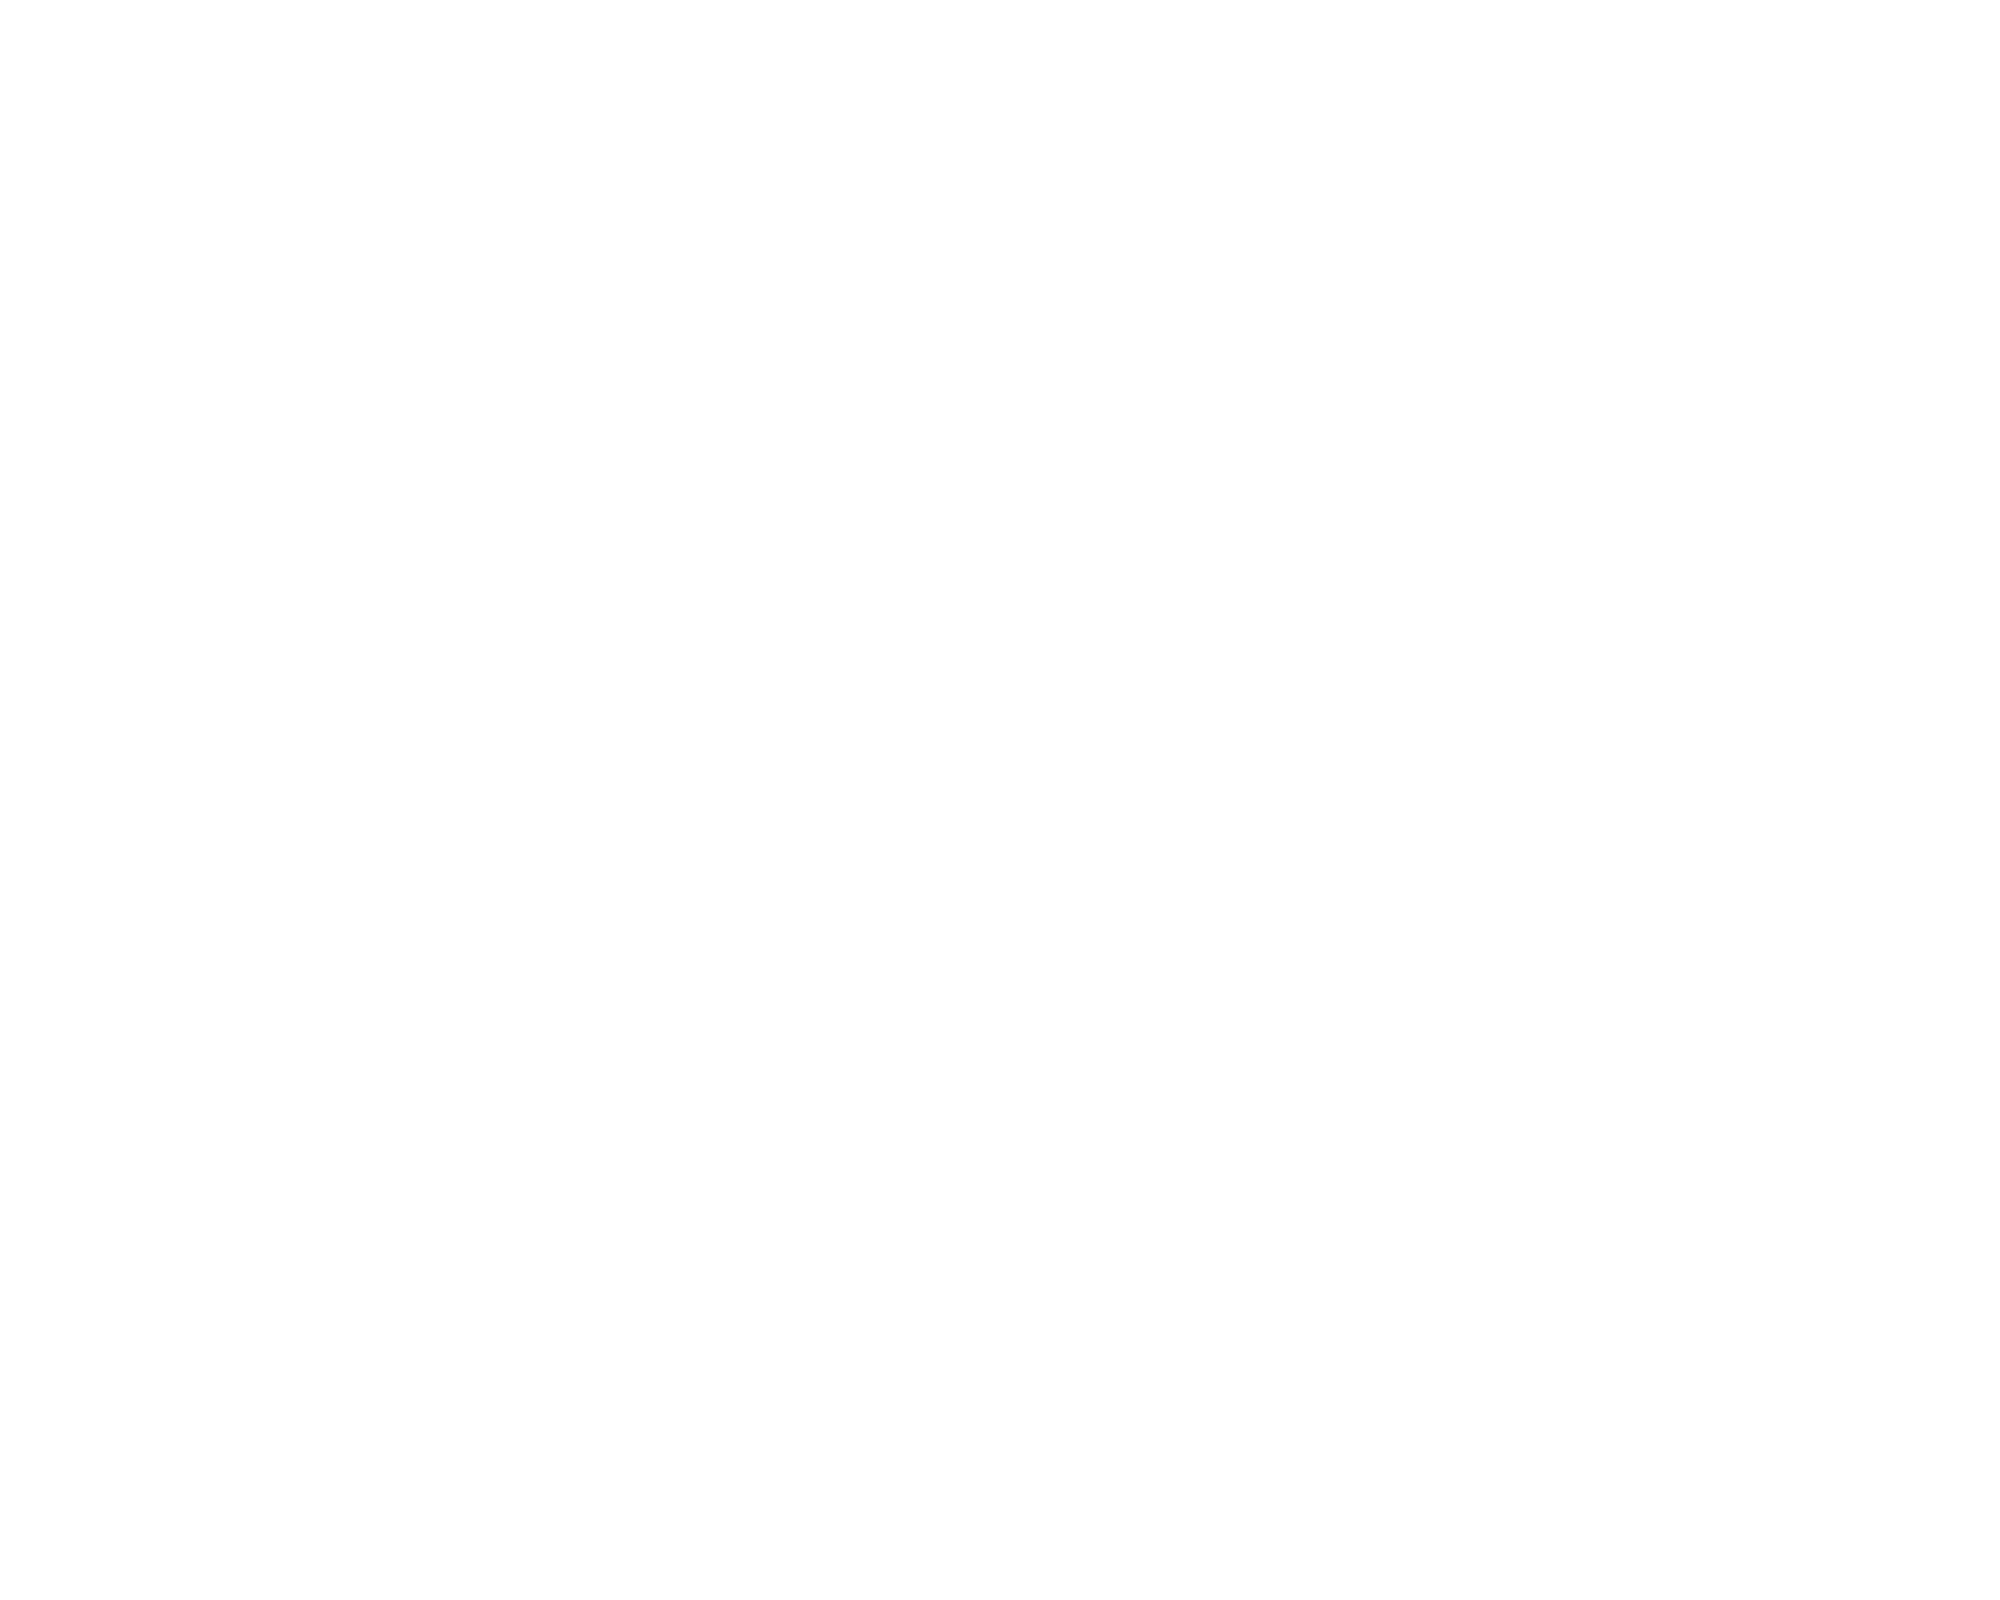

<IPython.core.display.Javascript object>


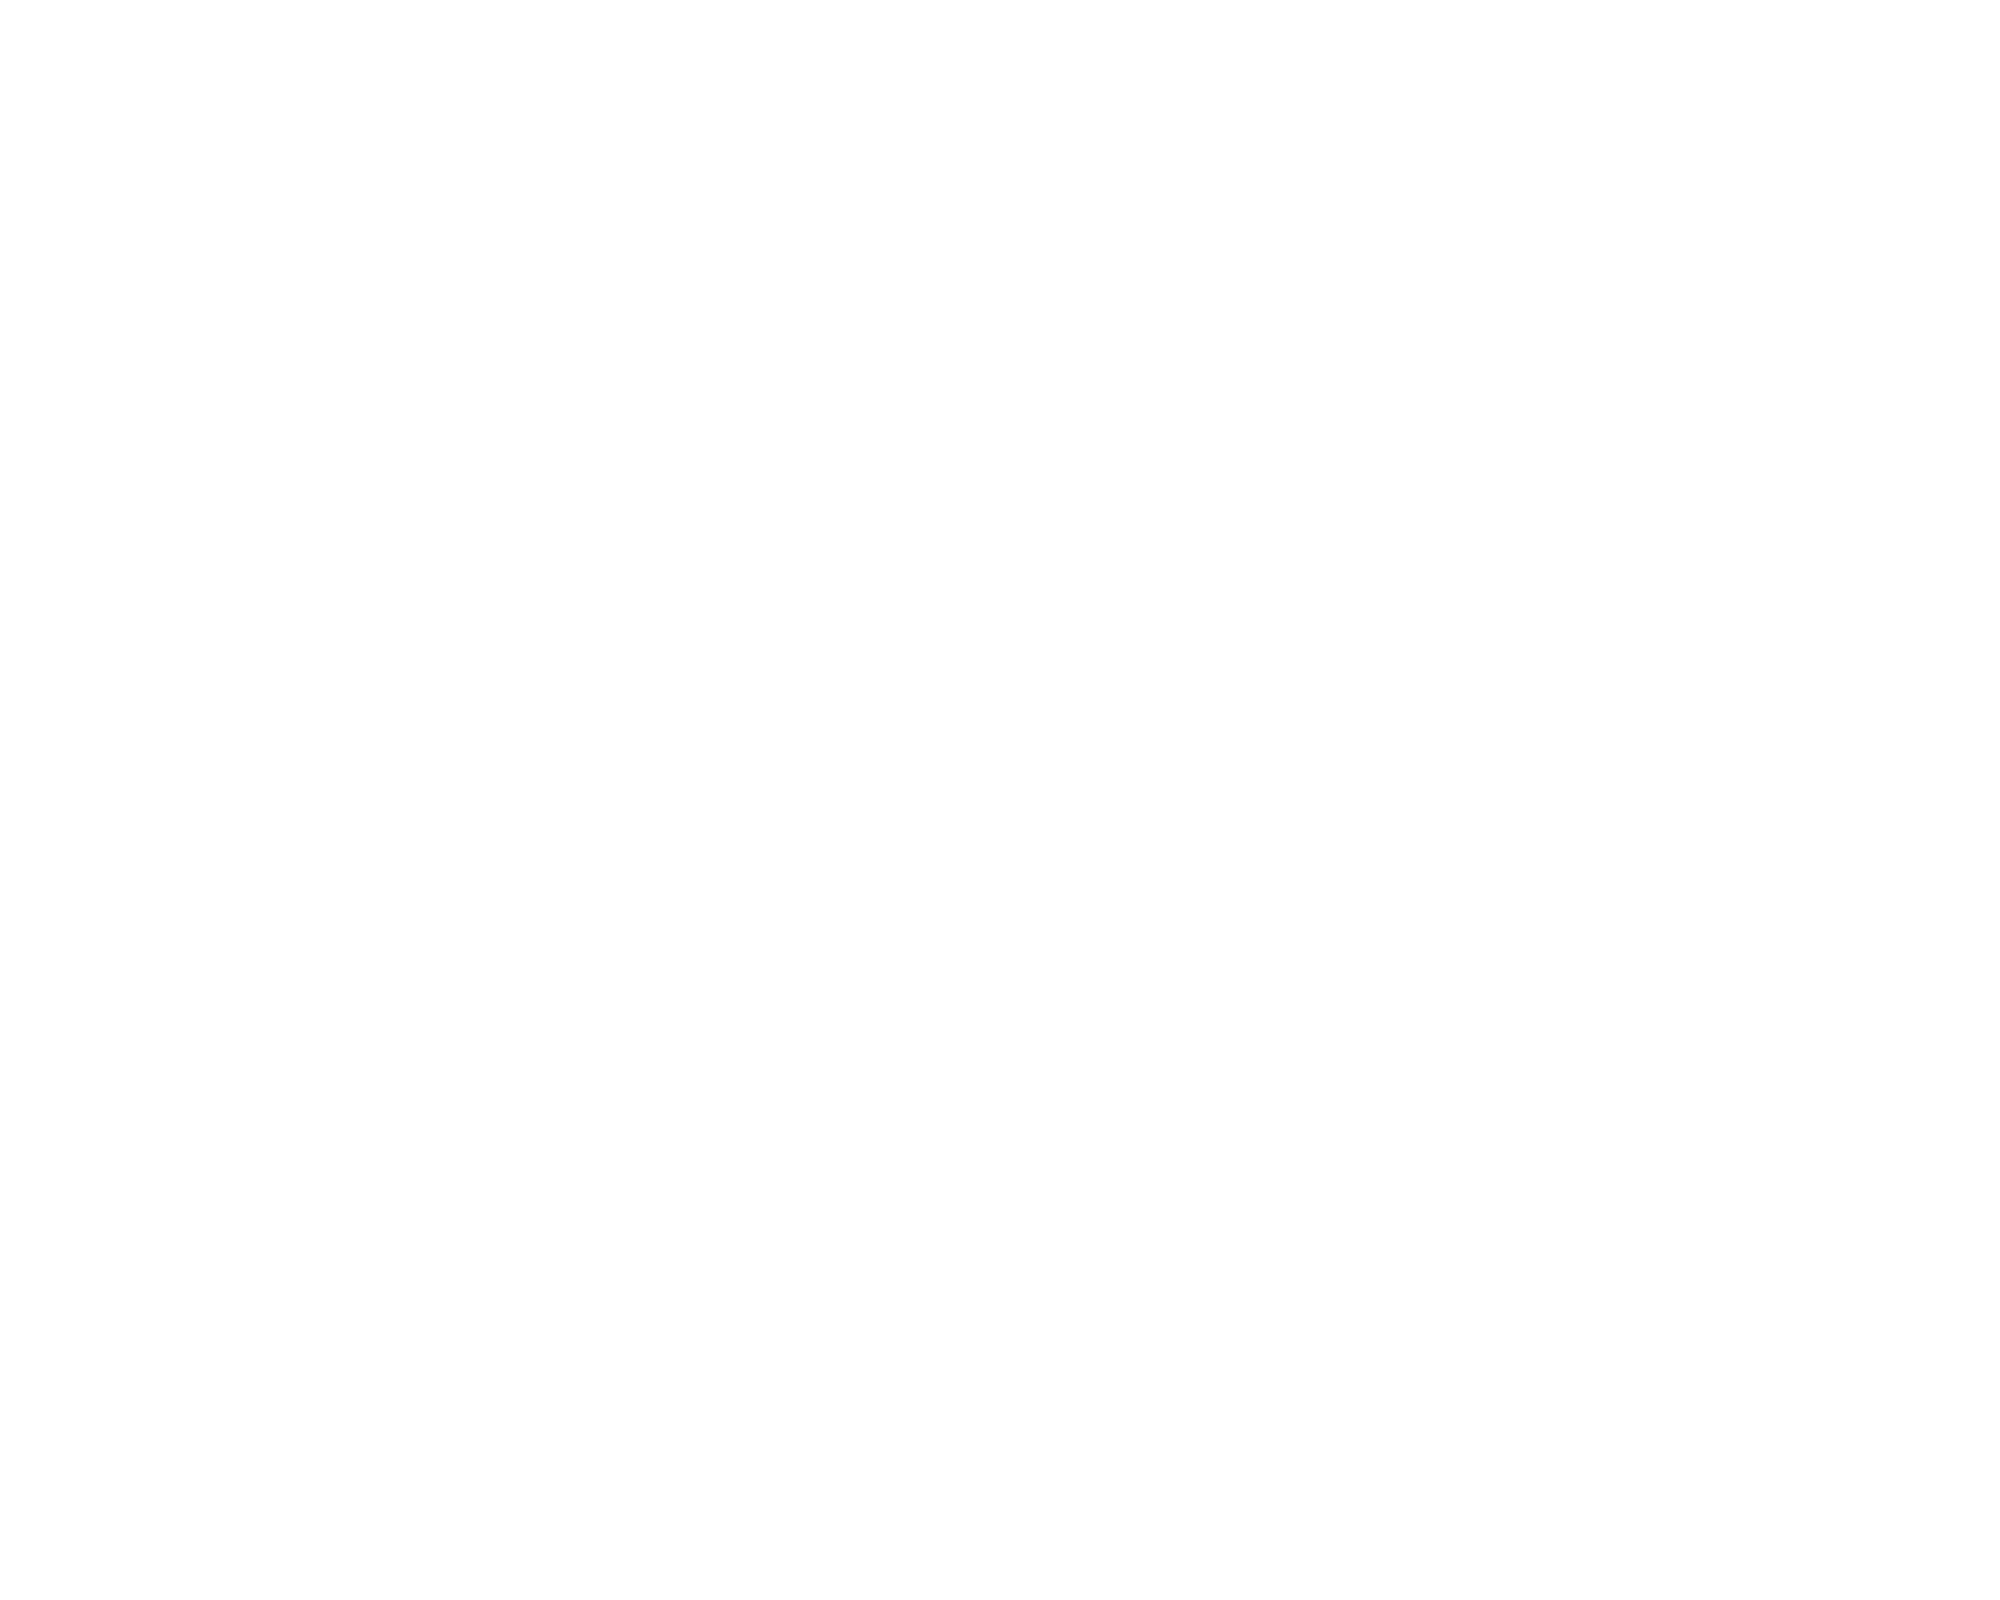

In [293]:
plt.rcParams["figure.figsize"] = (10, 8)
slope_tol = 10**(-7) # The maximum tolerated slope "angle_default_multistep" 
batch_number = 2

for l in range(len(objectss)): # Loop over all objects
    make_video(objectss, l, intens, time_stamps, vminn, vmaxx, False, margin_plot, True, True, batch_number) # Wide angle video
    
    #make_video(objectss, l, intens, time_stamps, vminn, vmaxx, True, margin_plot, True, True, batch_number) # Zoom-in video
    
    plot_separately_trajectory(objectss, l, intens, 'expand', 0, slope_tol, True, batch_number) # Horizontal fit
    
    #plot_separately_trajectory(objectss, l, intens, 'expand', np.pi / 4, slope_tol, True, batch_number) # 45 fit
    
    plot_separately_intens(objectss, l, intens, 'max', vminn, vmaxx, margin_plot, True, batch_number) # Max intensity, separate from the environments
    
    plot_separately_invivo(objectss, l, intens, time_stamps, vminn, vmaxx, True, margin_plot, True, batch_number) # no zoom
    
    plot_separately_invivo(objectss, l, intens, time_stamps, vminn, vmaxx, True, margin_plot, True, batch_number) # zoom
    
    #write_data(objectss, l, intens, slope_tol, batch_number) # Make the -H data file


In [ ]:
# Make a video of the whole field of view but with footpoints of all objects marked
annotated_video(objectss, intens, time_stamps, vminn, vmaxx, 2)


In [ ]:
plt.rcParams["figure.figsize"] = (7, 5)
indexx = 60
plot_separately_trajectory(objectss, indexx, intens, 'expand', 0, slope_tol, False, batch_number)
print(np.load(make_name(indexx, 'H', 2) + '.npy')[8])


In [251]:
# Histogram of objects by their ratios of principal moments of inertia

plt.rcParams["figure.figsize"] = (7, 5)
histo = []

for obj in objectss:
    (minor, major) = inertia(obj, intens, 1, 'max')
    histo.append(minor / major)

no_bins = 20
plt.hist(histo, no_bins, (0, 1), edgecolor = 'black', linewidth = 0.8)
plt.xlabel(r'$\tilde{I}$', fontsize = 12)
plt.title('Histogram of {} '.format(len(histo)) + r'objects by their $\tilde{I}$', fontsize = 12)
plt.show()


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


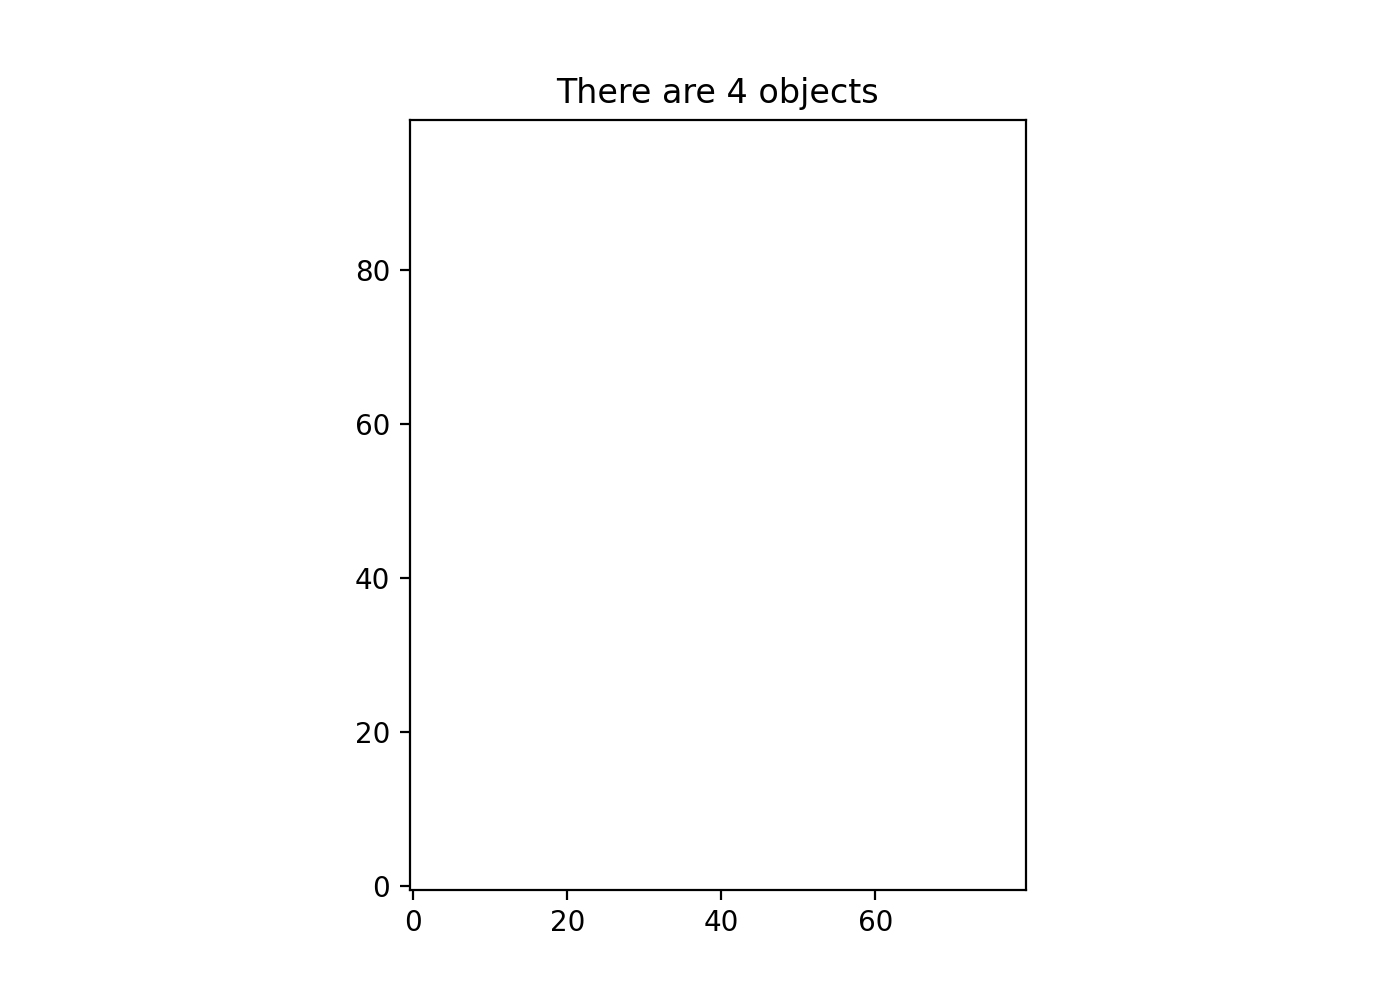

In [93]:
# Make an animation of how objects are tracked in time, without intensities

plt.rcParams["figure.figsize"] = (7, 5)
(ny, nx, nt) = intens.shape
arrayy = np.zeros((ny, nx, nt)) # Represents the objects

no = len(objectss) # Number of objects to animate

for i in range(no):
    ti1 = objectss[i][0]
    ti2 = ti1 + len(objectss[i][1:]) - 1

    for j in range(ti2 - ti1 + 1):
        for coord in objectss[i][1 + j]:
            arrayy[coord[0], coord[1], ti1 + j] = i + 1

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ims1 = []

arrayy = np.where(arrayy == 0, np.nan, arrayy) #NaN gets plotted to a white background

for p in range(nt):
    im1 = ax1.imshow(arrayy[:, :, p], vmin = 0, vmax = no, origin = 'lower', cmap = 'brg', animated=True)
    if p == 0:
        im1 = ax1.imshow(arrayy[:, :, p], vmin = 0, vmax = no, origin = 'lower', cmap = 'brg')
    ims1.append([im1])

if no != 1:
    plt.title('There are {} objects'.format(no), fontsize = 15)
if no == 1:
    plt.title('There is 1 object', fontsize = 15)

plt.xlabel('x [pixels]', fontsize = 15)
plt.ylabel('y [pixels]', fontsize = 15)
ani = animation.ArtistAnimation(fig1, ims1, interval = 200, blit = False)

HTML(ani.to_html5_video())


In [ ]:
# Make an animation of how objects are tracked in time, with intensities

(ny, nx, nt) = intens.shape
array_intens = np.zeros((ny, nx, nt)) # Represents the objects

no = len(objectss) # Number of objects to animate

for i in range(no):
    ti1 = objectss[i][0]
    ti2 = ti1 + len(objectss[i][1:]) - 1

    for j in range(ti2 - ti1 + 1):
        for coord in objectss[i][1 + j]:
            array_intens[coord[0], coord[1], ti1 + j] = intens[coord[0], coord[1], ti1 + j]

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ims1 = []

array_intens = np.where(array_intens == 0, vminn, array_intens)

for p in range(nt):
    im1 = ax1.imshow(array_intens[:, :, p], norm = colors.LogNorm(vmin = vminn, vmax = vmaxx), origin = 'lower', cmap = 'sdoaia193', animated=True)
    if p == 0:
        im1 = ax1.imshow(array_intens[:, :, p], norm = colors.LogNorm(vmin = vminn, vmax = vmaxx), origin = 'lower', cmap = 'sdoaia193')
    ims1.append([im1])

if no != 1:
    plt.title('There are {} objects'.format(no), fontsize = 15)
if no == 1:
    plt.title('There is 1 object', fontsize = 15)

plt.xlabel('x [pixels]', fontsize = 15)
plt.ylabel('y [pixels]', fontsize = 15)
ani = animation.ArtistAnimation(fig1, ims1, interval = 200, blit = False)

HTML(ani.to_html5_video())


<IPython.core.display.Javascript object>


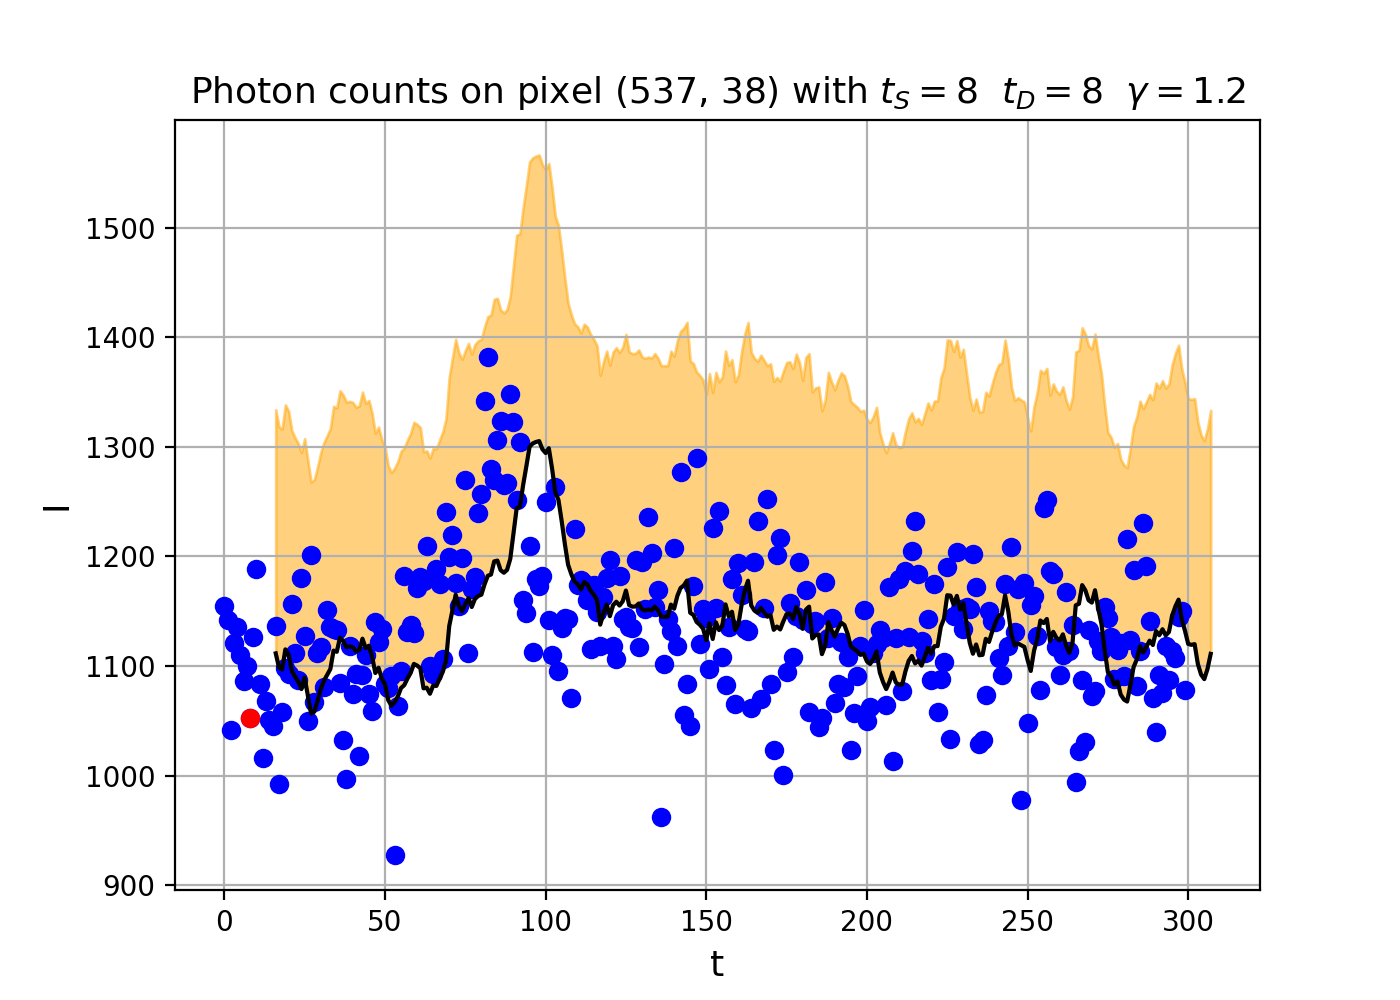

Standard deviation is 68.31
Mean value is 1135.8833878580729


In [186]:
# Photon counts vs time for a selected pixel

ycor0 = 0
xcor0 = 500
ycor = 38
xcor = 37
t_smooth2 = 8 # Smoothening time for the running mean
delay = 8 # Delay between calculating and comparing to the mean
thresh = 1.2 # Threshold for detection

bck_evol = intens[ycor, xcor, :]
means = np.zeros(bck_evol.shape[0]) # The first t_smooth2 entries are 0
for j in range(t_smooth2, bck_evol.shape[0]):
    means[j] = np.mean(bck_evol[j - t_smooth2 : j])
time_means = np.arange(t_smooth2 + delay, bck_evol.shape[0] + delay, 1) # At this times, we compare to the running mean

plt.plot(bck_evol, 'o', color='b')

plt.plot(t_smooth2, bck_evol[t_smooth2], 'o', color='r')
plt.plot(time_means, means[t_smooth2:], color='k')

plt.fill_between(time_means, means[t_smooth2:], thresh*means[t_smooth2:], alpha=0.5, color='orange')

plt.grid(True)
plt.xlabel('t', fontsize = 13)
plt.ylabel('I', fontsize = 13)
plt.title('Photon counts on pixel ({}, {}) with '.format(xcor+xcor0, ycor+ycor0) + r'$t_{S}=$'+'{}  '.format(t_smooth2) + r'$t_{D}=$'+'{}  '.format(delay) + r'$\gamma = $'+'{}'.format(thresh), fontsize = 13)
plt.show()

sigma = np.std(bck_evol, ddof = 1)  # Unbiased standard deviation
print('Standard deviation is {}'.format(np.around(sigma, 2)))
print('Mean value is {}'.format(np.mean(bck_evol))) # Mean over the whole time
